In [15]:
import numpy as np
import pandas as pd
import ta
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_ta as pta

In [16]:
def get_data_from_yfinance(symbol: str, interval: str = '1h', start_date: pd.Timestamp = None, end_date: pd.Timestamp = None, invert_pair: bool = False):
    ticker_data = yf.Ticker(symbol)
    
    if start_date is None or end_date is None:
        end_date = pd.Timestamp.now()
        start_date = end_date - pd.Timedelta(days=30)  # Default to 30 days if no dates provided

    df = ticker_data.history(interval=interval, start=start_date, end=end_date)
    
    # Convert column names to lowercase
    df.columns = [col.lower() for col in df.columns]

    # Rename 'date' column to match Kraken CSV format
    df = df.reset_index().rename(columns={'index': 'date'})
    
    # Add 'trades' column with NaN values to match Kraken CSV format
    df['trades'] = np.nan

    if invert_pair:
        # Invert the price columns (Open, High, Low, Close)
        for col in ['open', 'high', 'low', 'close']:
            df[col] = 1 / df[col]
        
        # Adjust the volume
        df['volume'] = df['volume'] * df['close']
        
        # Swap High and Low
        df['high'], df['low'] = 1 / df['low'], 1 / df['high']

    return df

# Example usage:
data = get_data_from_yfinance('BTC-USD', start_date=pd.Timestamp('2024-05-11'), end_date=pd.Timestamp('2024-06-26'))
data


Datetime          open          high           low  \
0    2024-05-11 00:00:00+00:00  60791.757812  60908.621094  60656.882812   
1    2024-05-11 01:00:00+00:00  60768.191406  61057.332031  60768.191406   
2    2024-05-11 02:00:00+00:00  60879.640625  60944.312500  60759.863281   
3    2024-05-11 03:00:00+00:00  60879.781250  60883.753906  60719.632812   
4    2024-05-11 04:00:00+00:00  60728.945312  60833.984375  60714.218750   
...                        ...           ...           ...           ...   
1099 2024-06-25 19:00:00+00:00  62150.968750  62258.261719  61830.597656   
1100 2024-06-25 20:00:00+00:00  61989.871094  62062.472656  61886.519531   
1101 2024-06-25 21:00:00+00:00  61880.535156  62000.121094  61823.863281   
1102 2024-06-25 22:00:00+00:00  61930.312500  62147.949219  61872.171875   
1103 2024-06-25 23:00:00+00:00  61902.218750  61928.324219  61675.003906   

             close  volume  dividends  stock splits  trades  
0     60782.218750       0        0.0           0.0     NaN  
1     60870.664062       0        0.0           0.0     NaN  
2     60859.140625       0        0.0           0.0     NaN  
3     60719.632812       0        0.0           0.0     NaN  
4     60773.367188       0        0.0           0.0     NaN  
...            ...     ...        ...           ...     ...  
1099  62134.644531       0        0.0           0.0     NaN  
1100  61890.632812       0        0.0           0.0     NaN  
1101  61888.550781       0        0.0           0.0     NaN  
1102  61901.339844       0        0.0           0.0     NaN  
1103  61808.593750       0        0.0           0.0     NaN  

[1104 rows x 9 columns]

In [17]:
base_kraken_path = '../data/kraken'

def get_data_from_kraken_csv(symbol: str, interval: str, window: int = None, skip: int = None, buffer: int = None, start_date: pd.Timestamp = None, end_date: pd.Timestamp = None):
    column_names = ['date_unix', 'open', 'high', 'low', 'close', 'volume', 'trades']
    df = pd.read_csv(f'{base_kraken_path}/{symbol}_{interval}.csv', names=column_names)
    
    df['date'] = pd.to_datetime(df['date_unix'], unit='s')
    del df['date_unix']
    df = df.set_index('date')

    if start_date is not None and end_date is not None:
        df = df[start_date:end_date]
    else:
        start_index = max(len(df) - window - buffer - window * skip, 0)
        end_index = max(len(df) - window * skip, 0)
        df = df.iloc[start_index:end_index]
    return df

#data = get_data_from_kraken_csv('XBTUSDT', '60', 720, 4, 168)
data = get_data_from_kraken_csv('XBTUSDT', '60', start_date=pd.Timestamp('2021-09-01'), end_date=pd.Timestamp('2021-10-01'))
data

open     high      low    close    volume  trades
date                                                                     
2021-09-01 00:00:00  47103.8  47289.0  46748.9  46763.4  6.454117     136
2021-09-01 01:00:00  46734.3  46861.4  46560.6  46861.4  7.247905     145
2021-09-01 02:00:00  46820.3  47084.7  46761.6  46874.0  0.933202      67
2021-09-01 03:00:00  46868.9  47005.4  46740.3  47005.4  1.168069      91
2021-09-01 04:00:00  47022.6  47240.2  46981.9  47129.4  4.546941     119
...                      ...      ...      ...      ...       ...     ...
2021-09-30 20:00:00  43558.6  43735.6  43156.3  43431.8  7.368952     168
2021-09-30 21:00:00  43408.6  43787.5  43390.9  43787.5  3.137095     163
2021-09-30 22:00:00  43785.4  43898.4  43652.8  43742.9  4.778271     103
2021-09-30 23:00:00  43753.7  43890.0  43637.9  43824.0  2.340164      45
2021-10-01 00:00:00  43804.5  44049.6  43696.6  43746.7  4.633744     108

[721 rows x 6 columns]

# Simple indicators

In [18]:
data = get_data_from_yfinance('SOL-BTC', start_date=pd.Timestamp('2022-12-01'), end_date=pd.Timestamp('2023-01-01'), invert_pair=False)

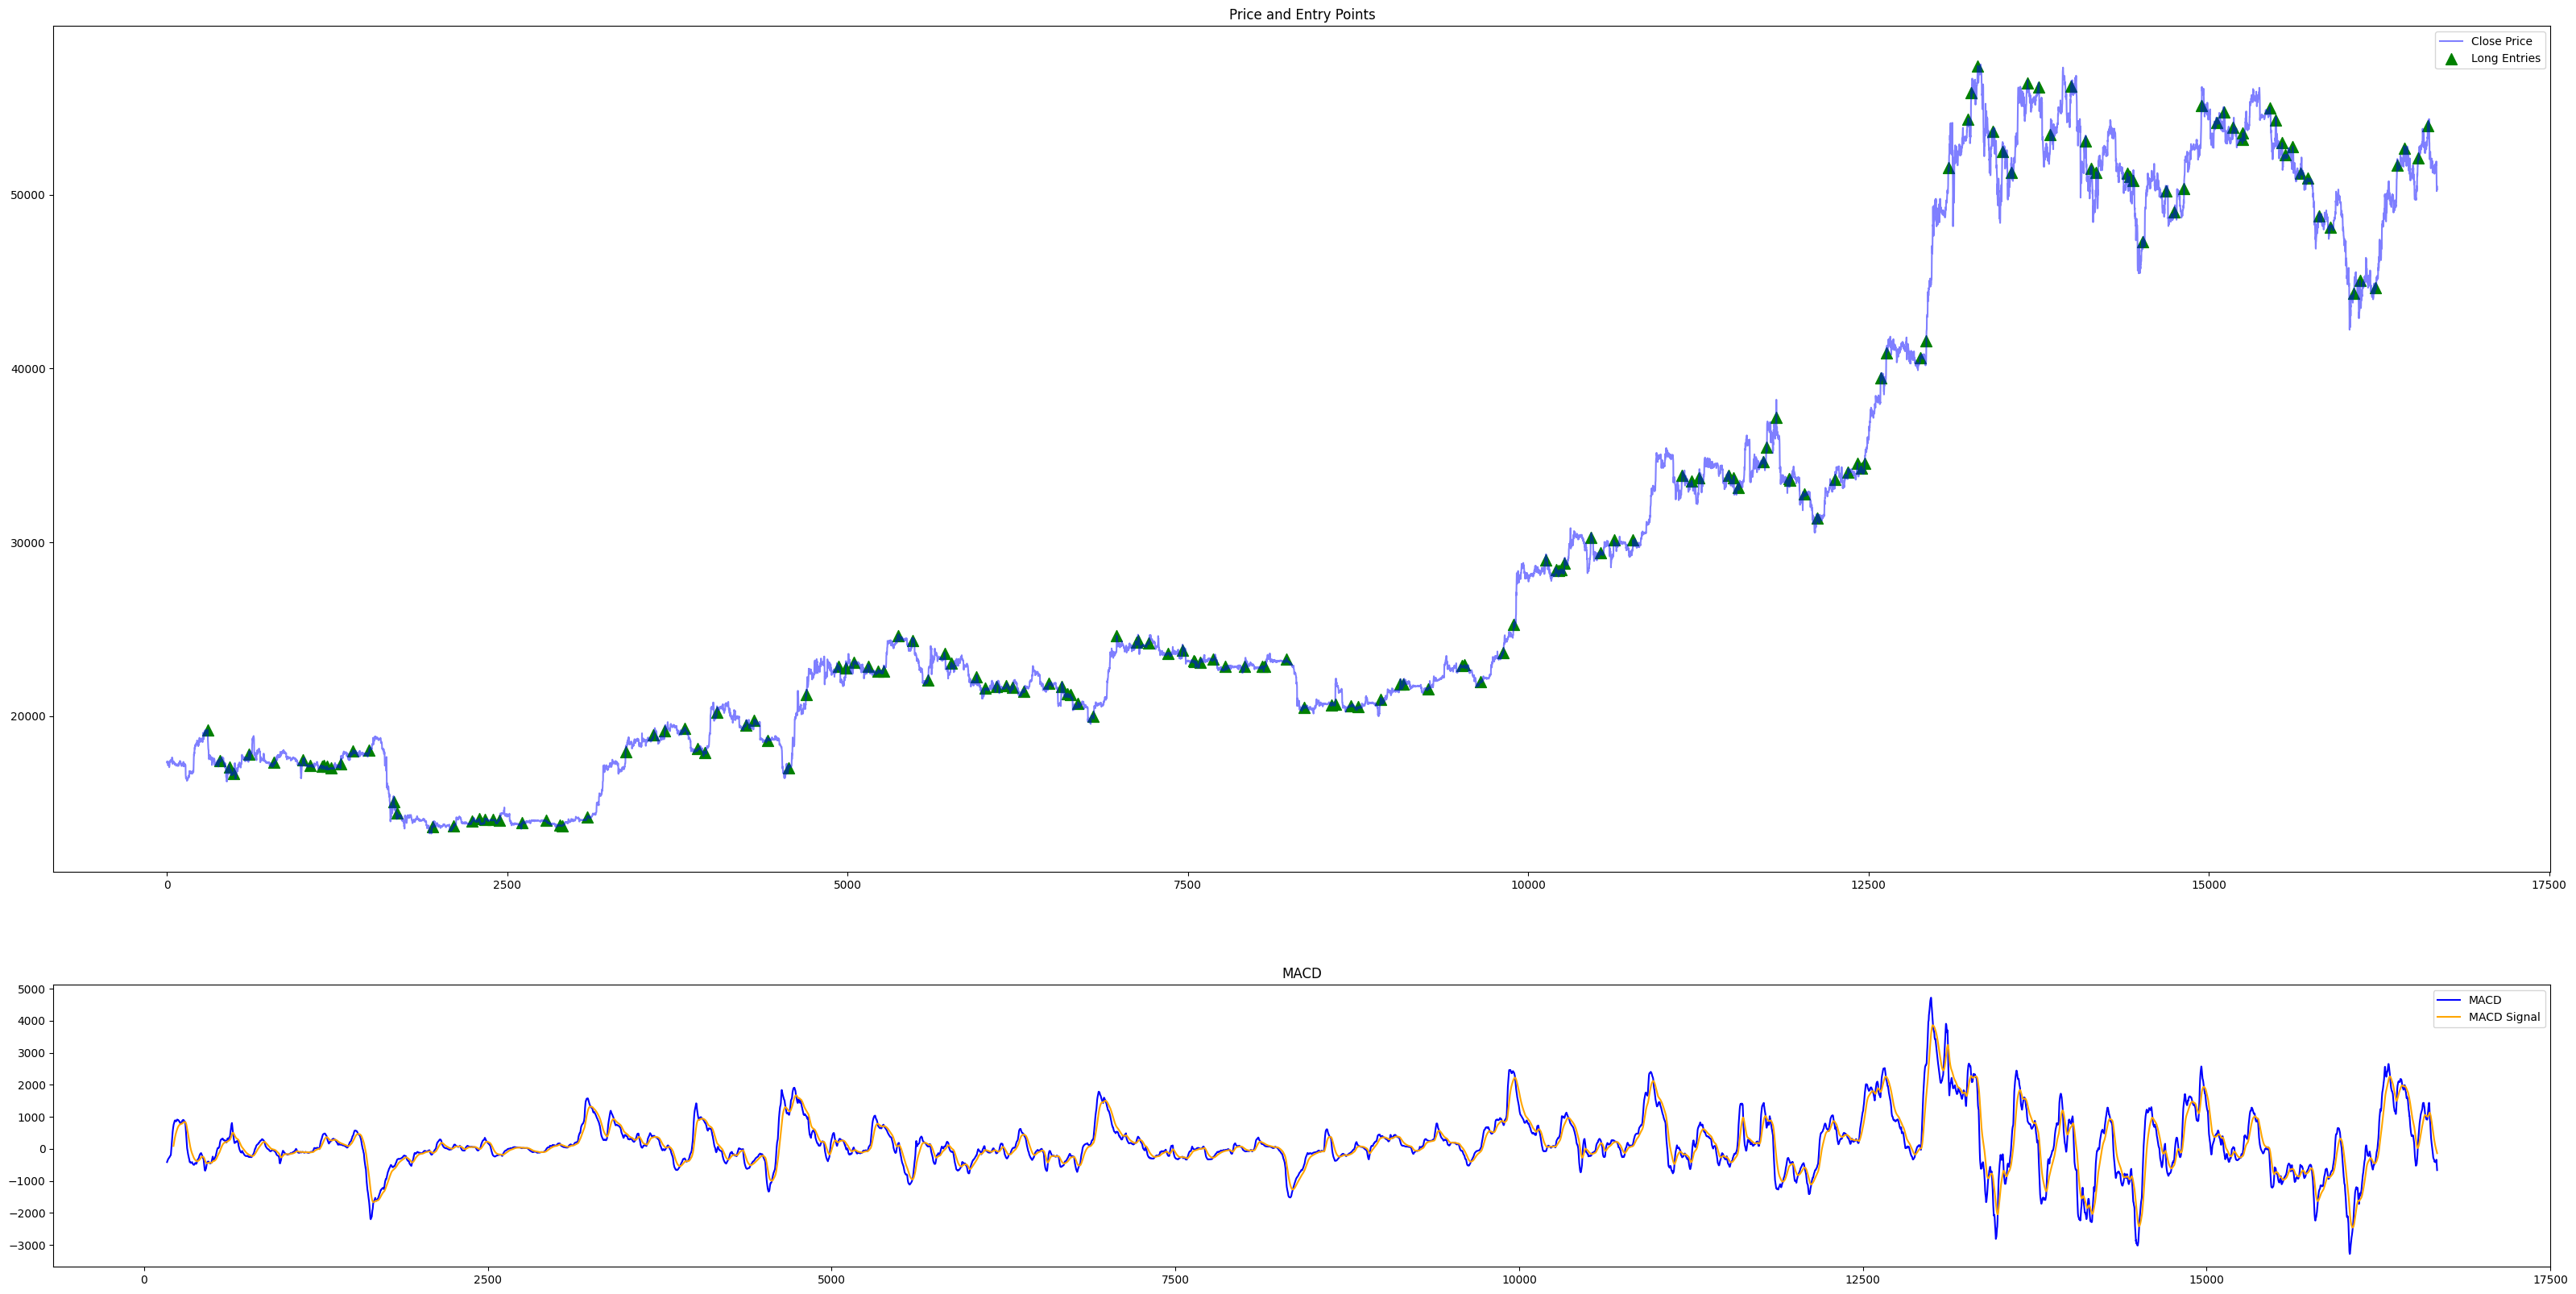

In [32]:
# Calculate MACD and its signal line
data['macd'] = ta.trend.macd(data['close'], window_slow=168, window_fast=24)
data['macd_signal'] = ta.trend.macd_signal(data['close'], window_slow=168, window_fast=24, window_sign=48)

data['macd_last'] = data['macd'].shift(1)
data['macd_signal_last'] = data['macd_signal'].shift(1)

data['long_entry'] = (data['macd'] > data['macd_signal']) & (data['macd_last'] < data['macd_signal_last'])
data['short_entry'] = (data['macd_signal'] < data['macd'])

# Plotting the price, MACD, RSI, and CCI for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
#ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price and Entry Points')
ax1.legend()

# Plot MACD
ax2.plot(data['macd'], label='MACD', color='blue')
ax2.plot(data['macd_signal'], label='MACD Signal', color='orange')
ax2.set_title('MACD')
ax2.legend()

plt.show()


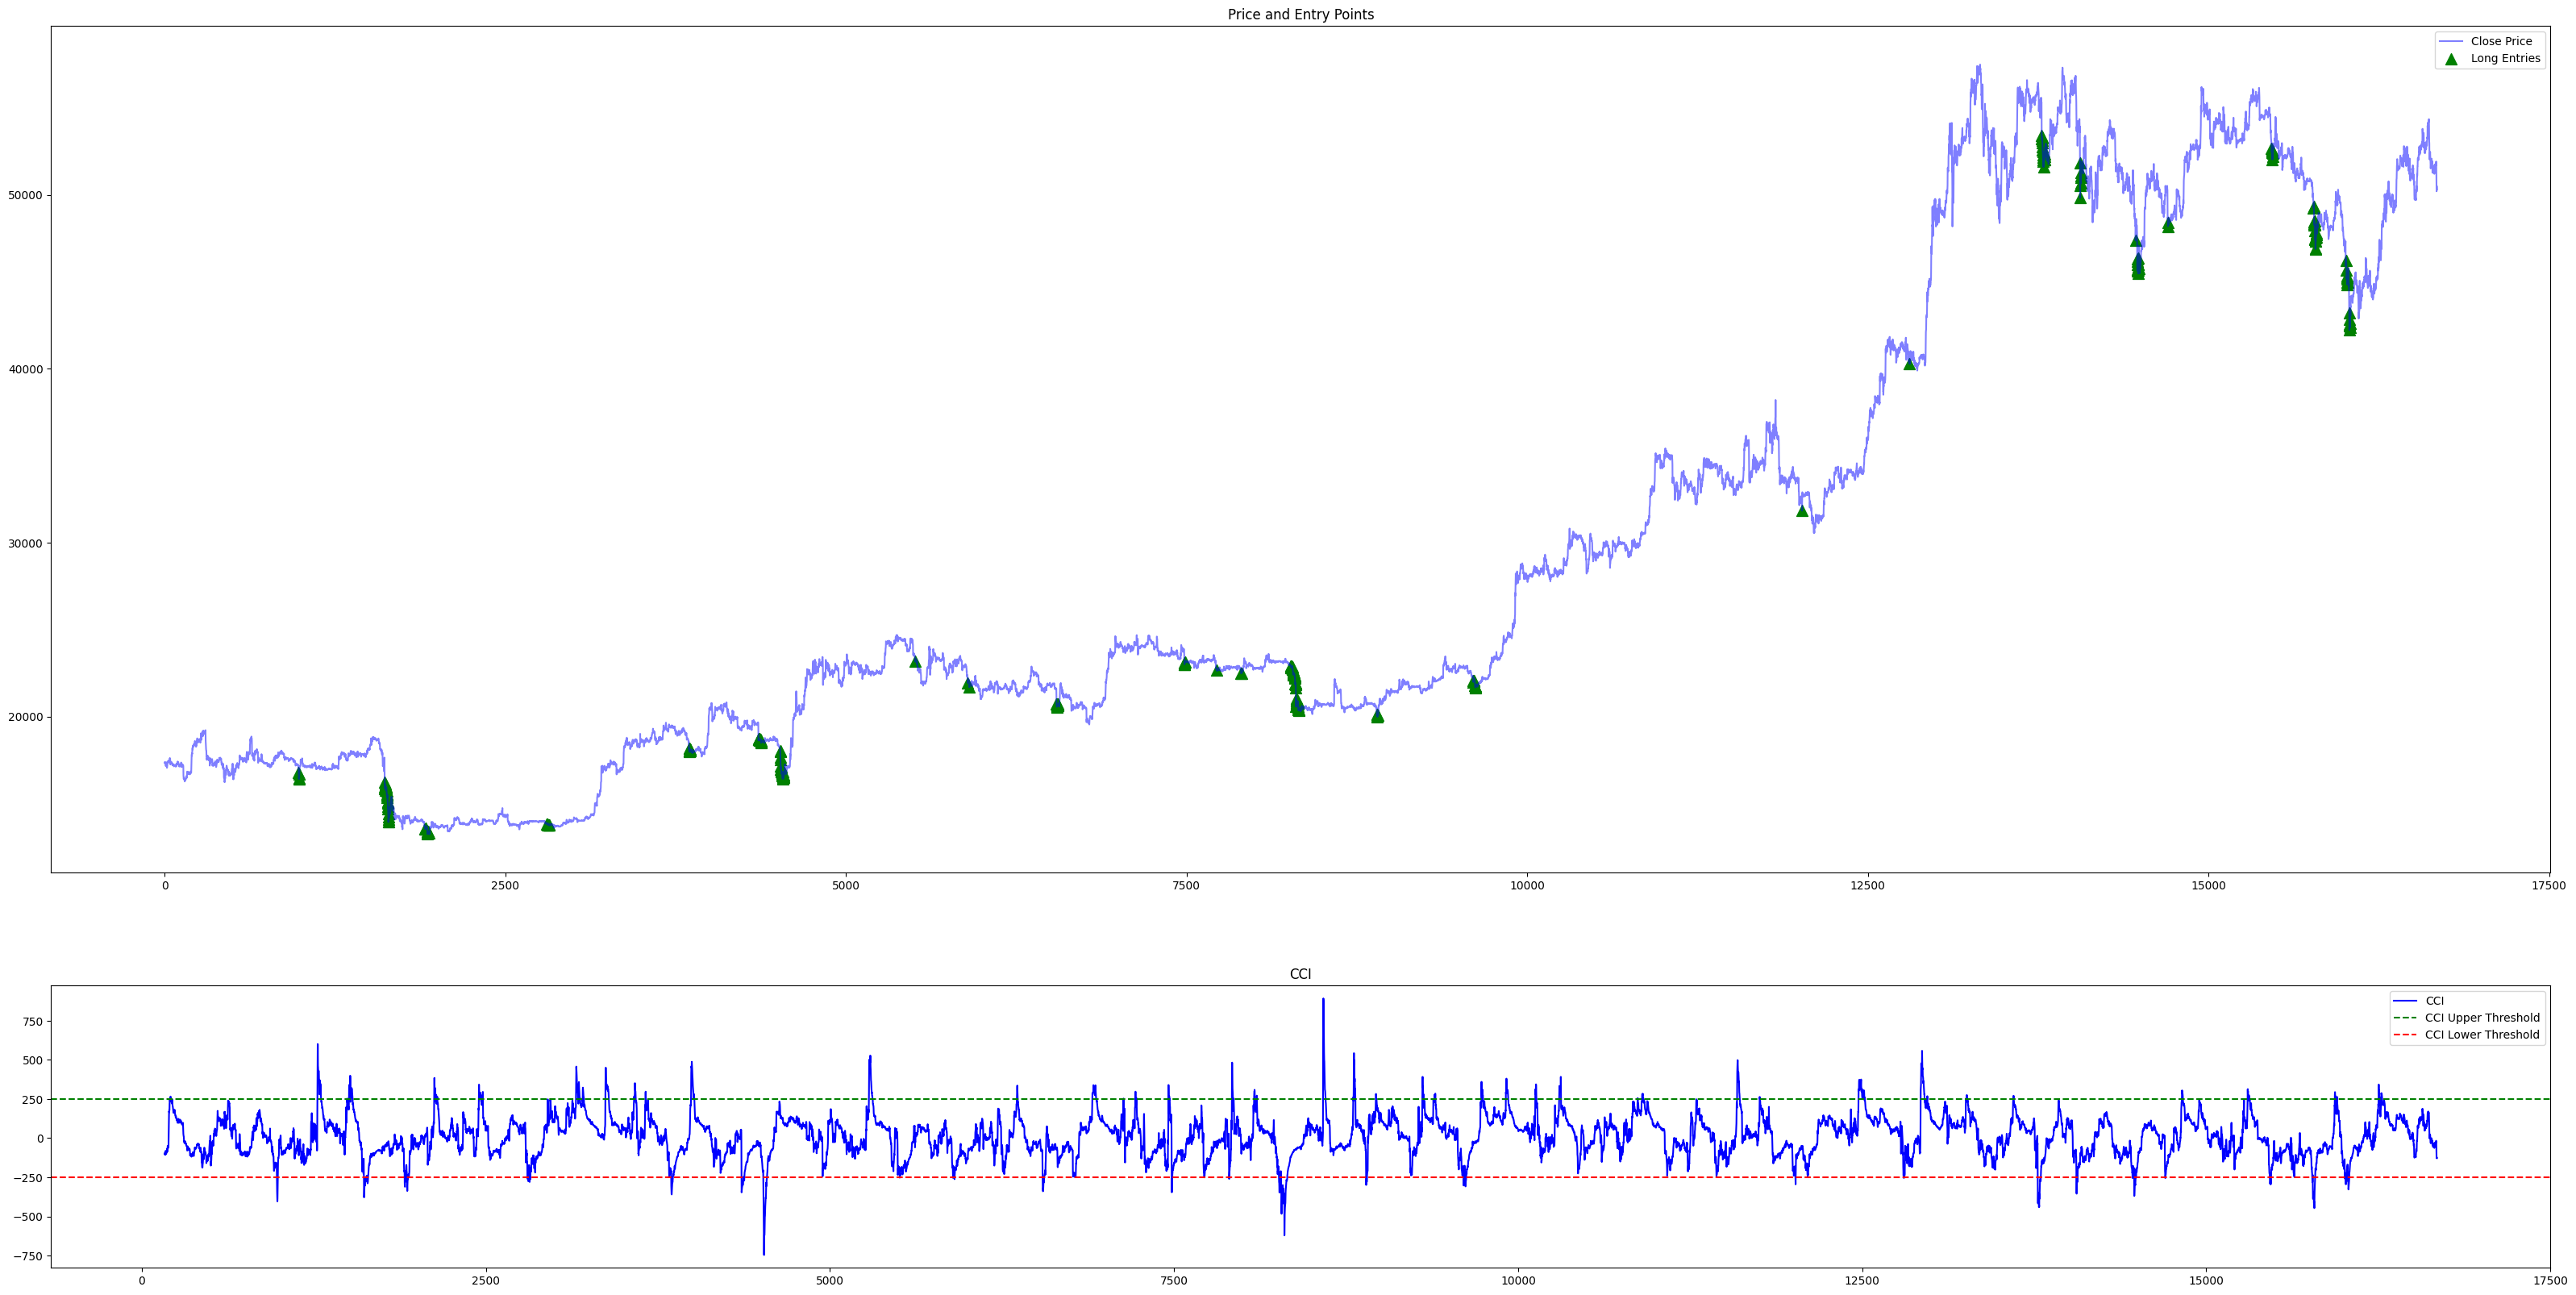

In [41]:
# Calculate CCI
data['cci'] = ta.trend.cci(data['high'], data['low'], data['close'], window=168)

# Define CCI trend direction with a reasonable margin
cci_upper_threshold = 250
cci_lower_threshold = -250
data['cci_oversold'] = data['cci'] < cci_lower_threshold
data['cci_overbought'] = data['cci'] > cci_upper_threshold

data['long_entry'] = data['cci_oversold']
data['short_entry'] = data['cci_overbought']

# Plotting the price, CCI, RSI, and CCI for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
#ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price and Entry Points')
ax1.legend()

# Plot CCI
ax2.plot(data['cci'], label='CCI', color='blue')
ax2.axhline(y=cci_upper_threshold, color='green', linestyle='--', label='CCI Upper Threshold')
ax2.axhline(y=cci_lower_threshold, color='red', linestyle='--', label='CCI Lower Threshold')
ax2.set_title('CCI')
ax2.legend()

plt.show()

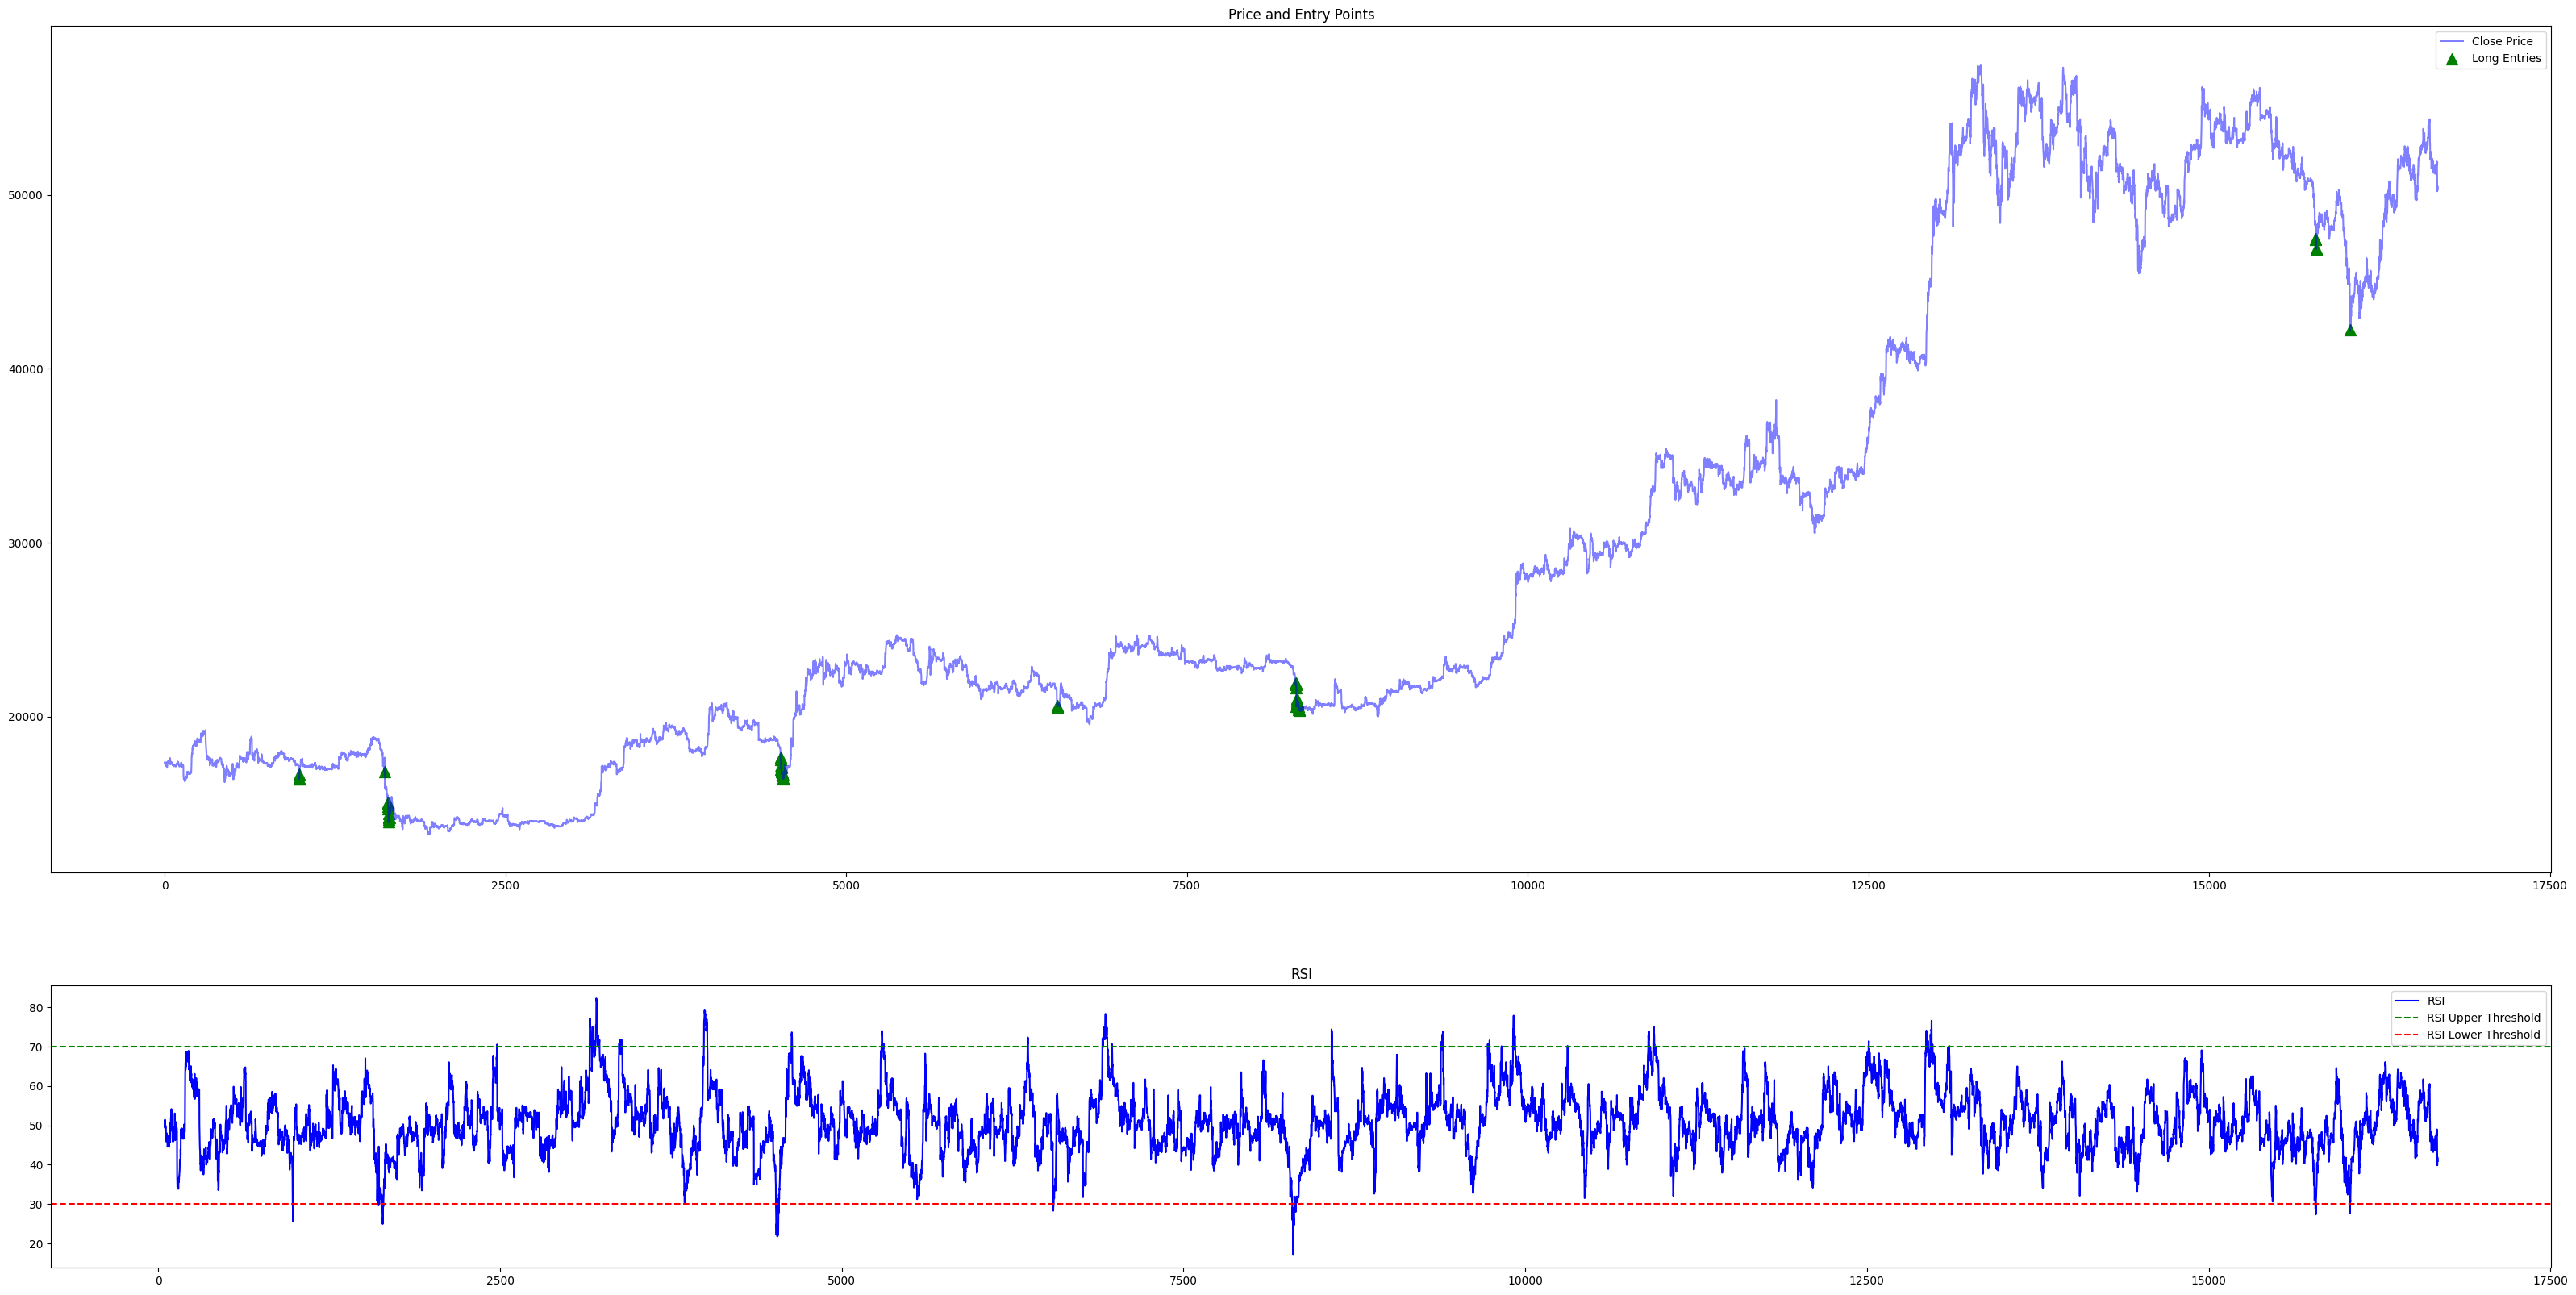

In [37]:
# Calculate RSI
data['rsi'] = ta.momentum.rsi(data['close'], window=48)

# Define RSI trend direction with a reasonable margin
rsi_upper_threshold = 70
rsi_lower_threshold = 30
data['rsi_oversold'] = data['rsi'] < rsi_lower_threshold
data['rsi_overbought'] = data['rsi'] > rsi_upper_threshold

data['long_entry'] = data['rsi_oversold']
data['short_entry'] = data['rsi_overbought']

# Plotting the price and RSI for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
#ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price and Entry Points')
ax1.legend()

# Plot RSI
ax2.plot(data['rsi'], label='RSI', color='blue')
ax2.axhline(y=rsi_upper_threshold, color='green', linestyle='--', label='RSI Upper Threshold')
ax2.axhline(y=rsi_lower_threshold, color='red', linestyle='--', label='RSI Lower Threshold')
ax2.set_title('RSI')
ax2.legend()

plt.show()

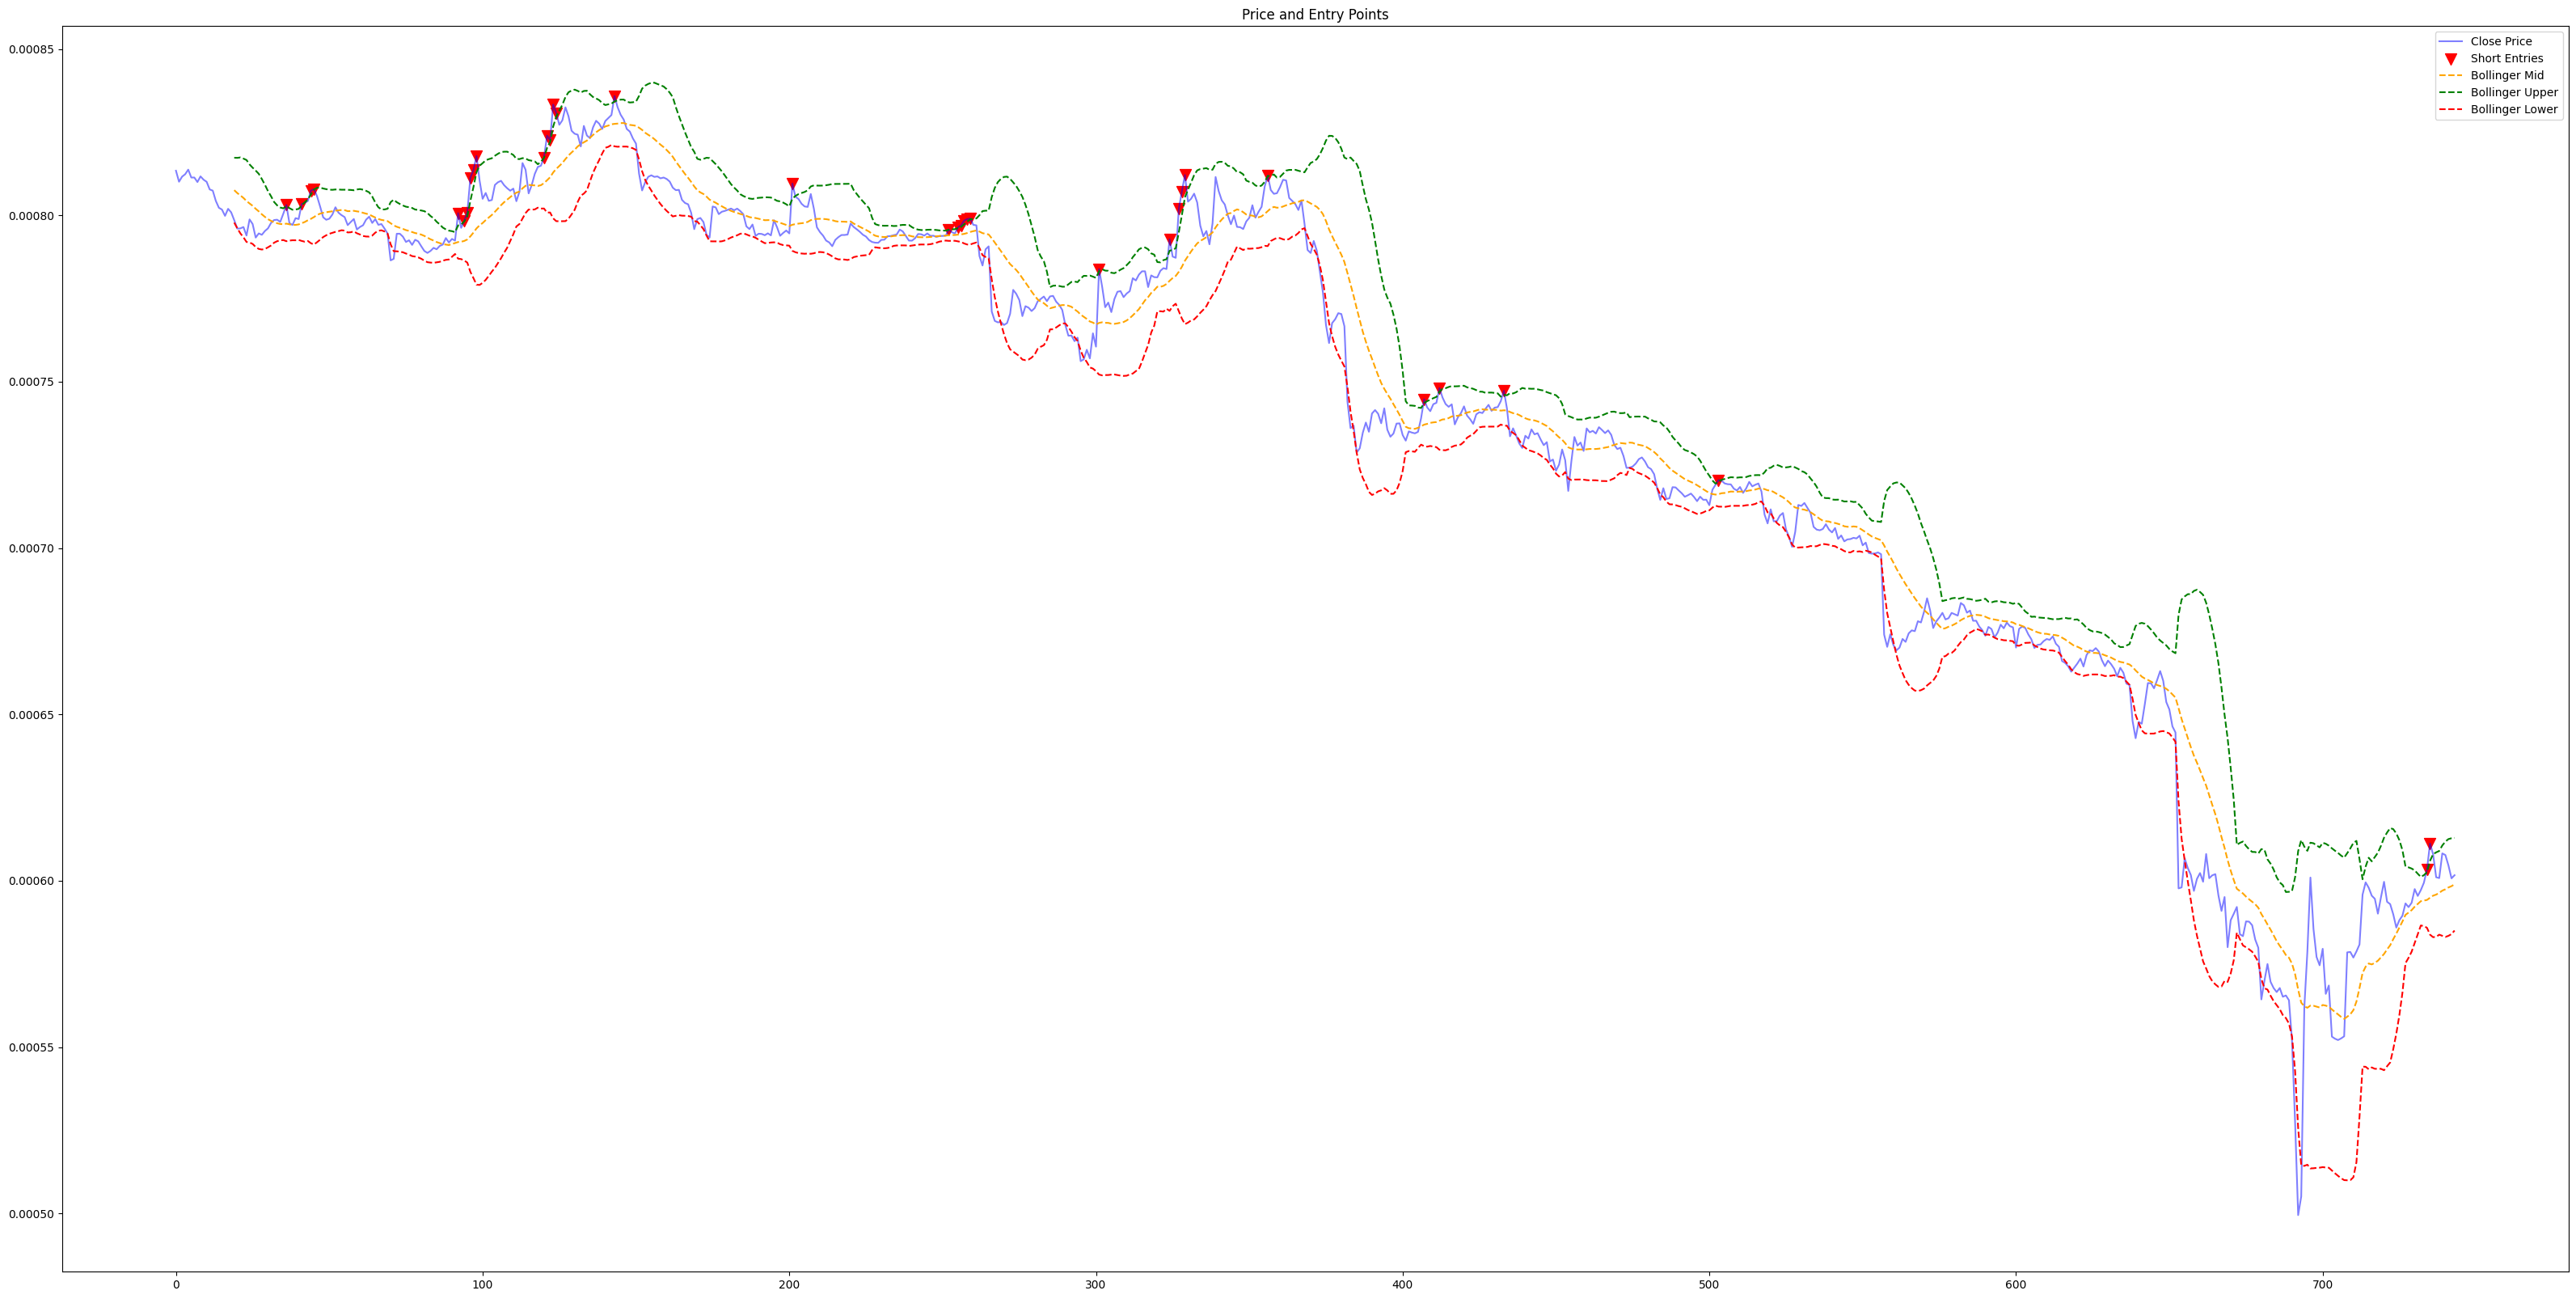

In [22]:
# Calculate Bollinger Bands
data['bollinger_mid'] = ta.volatility.bollinger_mavg(data['close'])
data['bollinger_upper'] = ta.volatility.bollinger_hband(data['close'])
data['bollinger_lower'] = ta.volatility.bollinger_lband(data['close'])

# Define Bollinger Bands trend direction with a minimum margin for the cross-over
data['long_entry'] = data['close'] < data['bollinger_lower']
data['short_entry'] = data['close'] > data['bollinger_upper']

# Plotting the price and Bollinger Bands for visualization
fig, (ax1) = plt.subplots(1, 1, figsize=(40, 20))

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
#ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.plot(data['bollinger_mid'], label='Bollinger Mid', color='orange', linestyle='--')
ax1.plot(data['bollinger_upper'], label='Bollinger Upper', color='green', linestyle='--')
ax1.plot(data['bollinger_lower'], label='Bollinger Lower', color='red', linestyle='--')
ax1.set_title('Price and Entry Points')
ax1.legend()

plt.show()

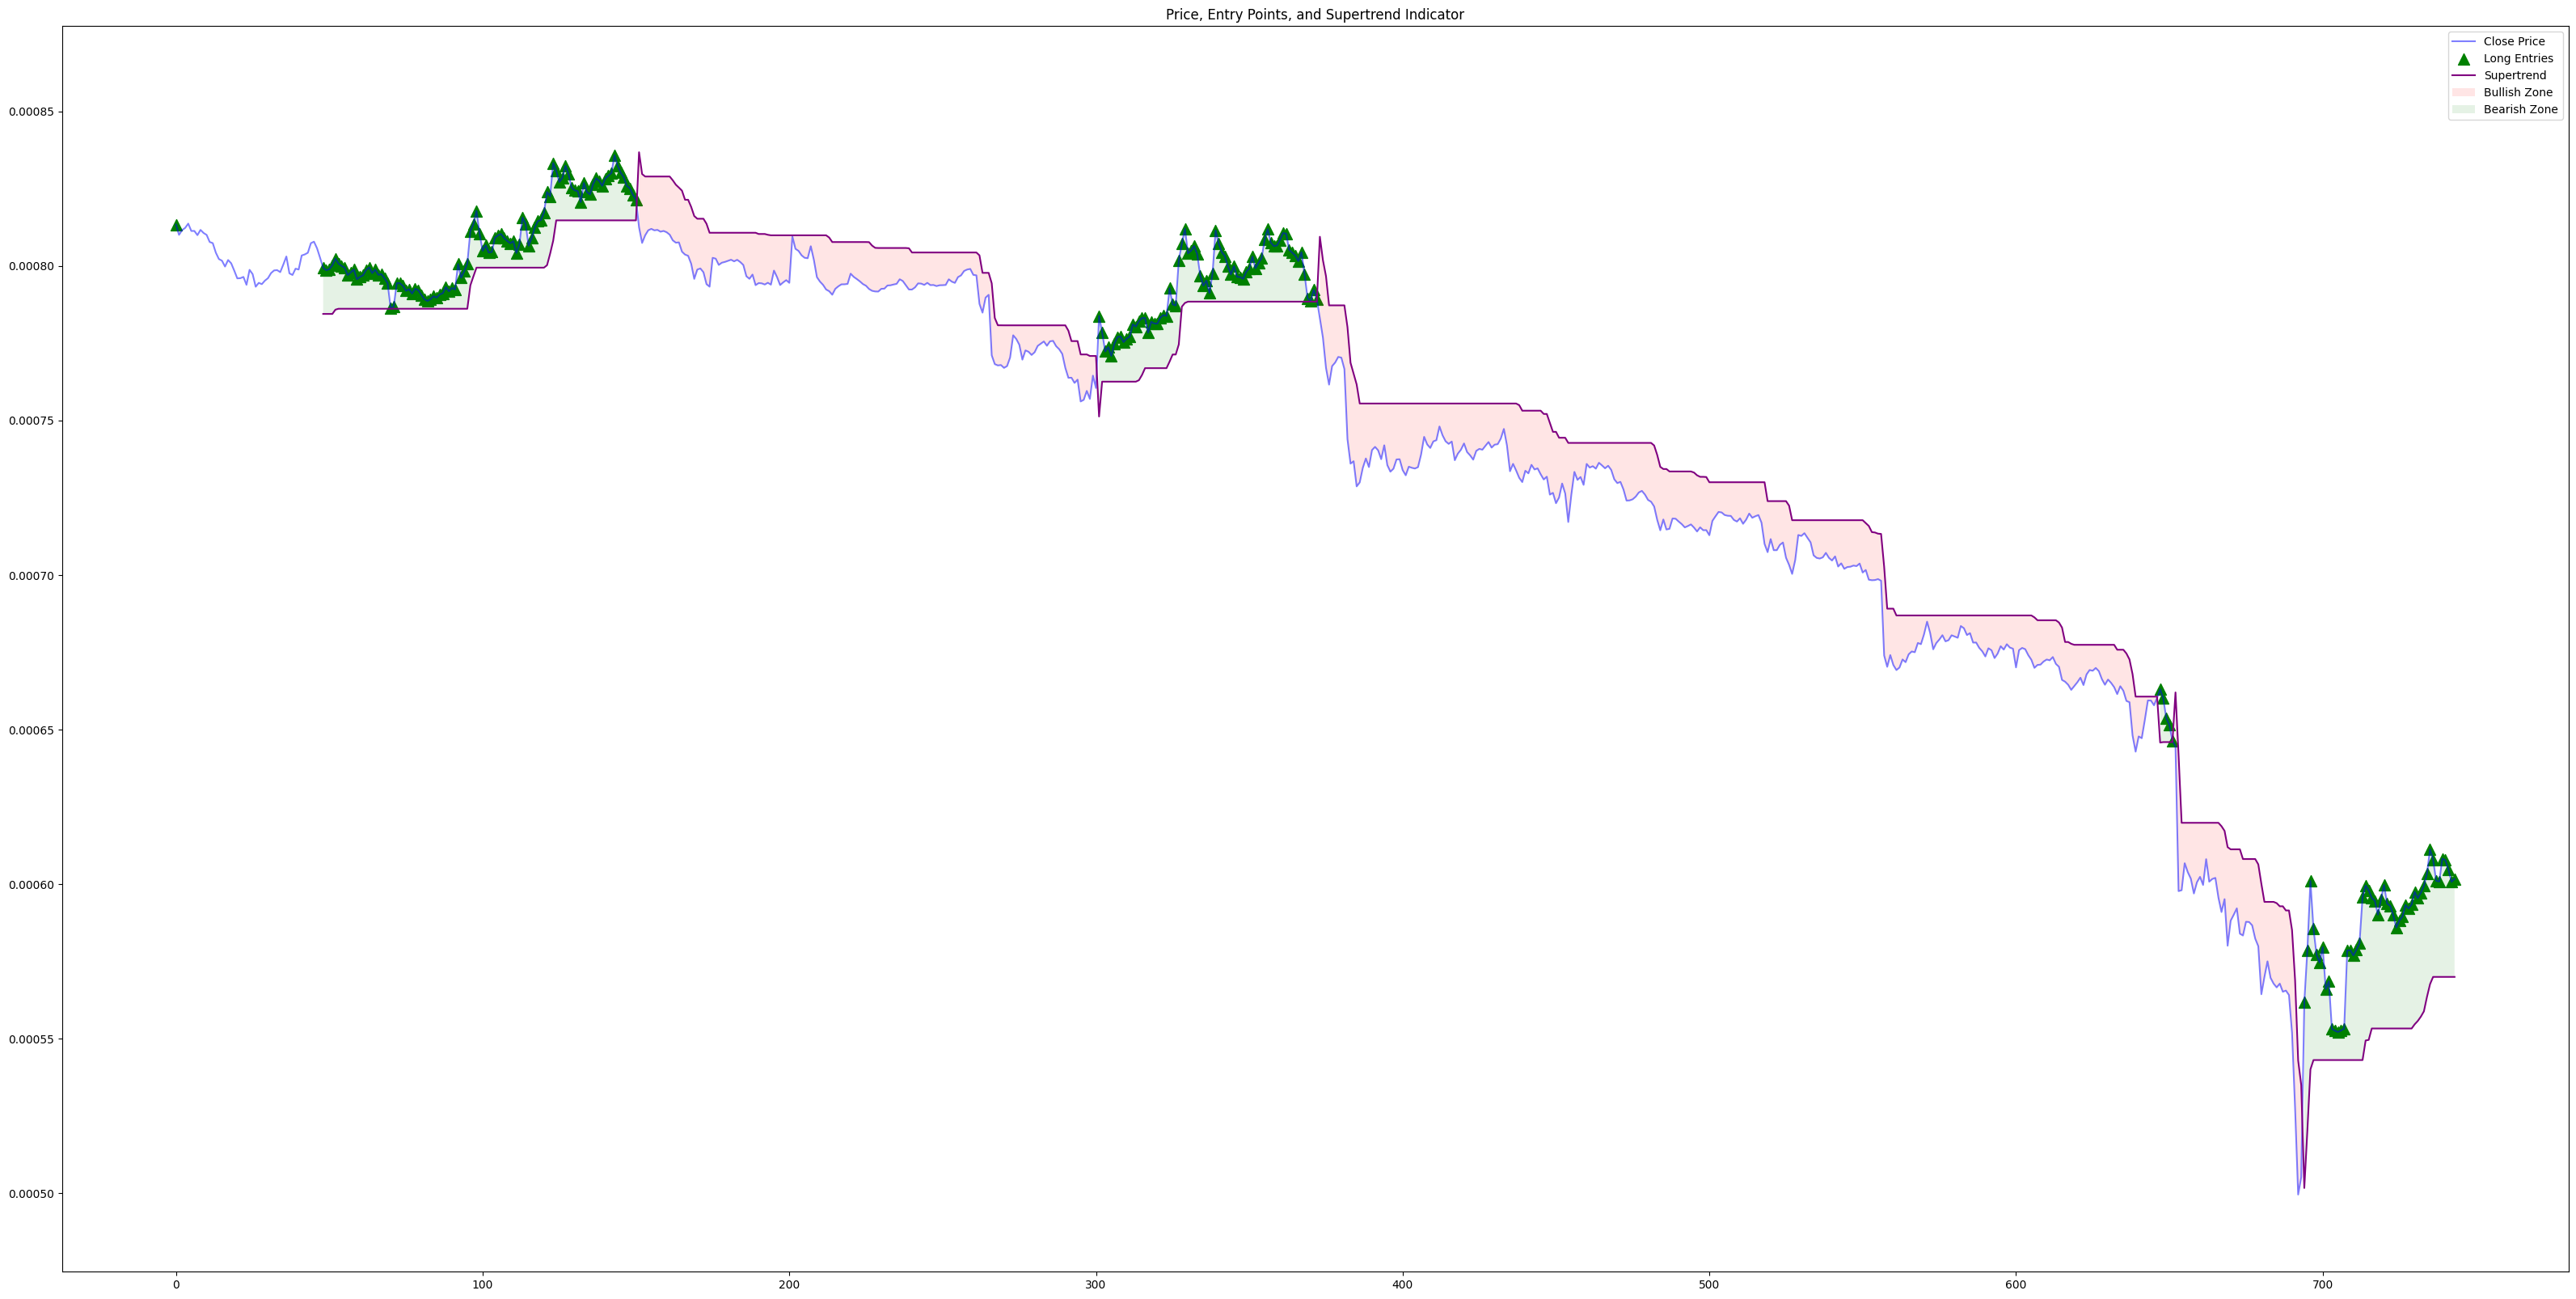

In [23]:
# Calculate Supertrend using pandas_ta
import pandas_ta as pta

supertrend_data = pta.supertrend(data['high'], data['low'], data['close'], length=48, multiplier=5)
data['supertrend'] = supertrend_data['SUPERT_48_5.0']

# Define Supertrend trend direction for entry and exit
data['long_entry'] = (data['supertrend'] <= data['close'])

# Plotting the price and Supertrend for visualization
fig, ax1 = plt.subplots(1, 1, figsize=(40, 20))

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)

# Overlay Supertrend on the same axis as price
ax1.plot(data['supertrend'], label='Supertrend', color='purple')
ax1.fill_between(data.index, data['supertrend'], data['close'], where=data['supertrend'] > data['close'], facecolor='red', alpha=0.1, label='Bullish Zone')
ax1.fill_between(data.index, data['supertrend'], data['close'], where=data['supertrend'] < data['close'], facecolor='green', alpha=0.1, label='Bearish Zone')

ax1.set_title('Price, Entry Points, and Supertrend Indicator')
ax1.legend()

ax1.set_ylim(data['close'].min() * .95, data['close'].max() * 1.05)  # Set y-axis scale from 35000 to 50000

plt.show()



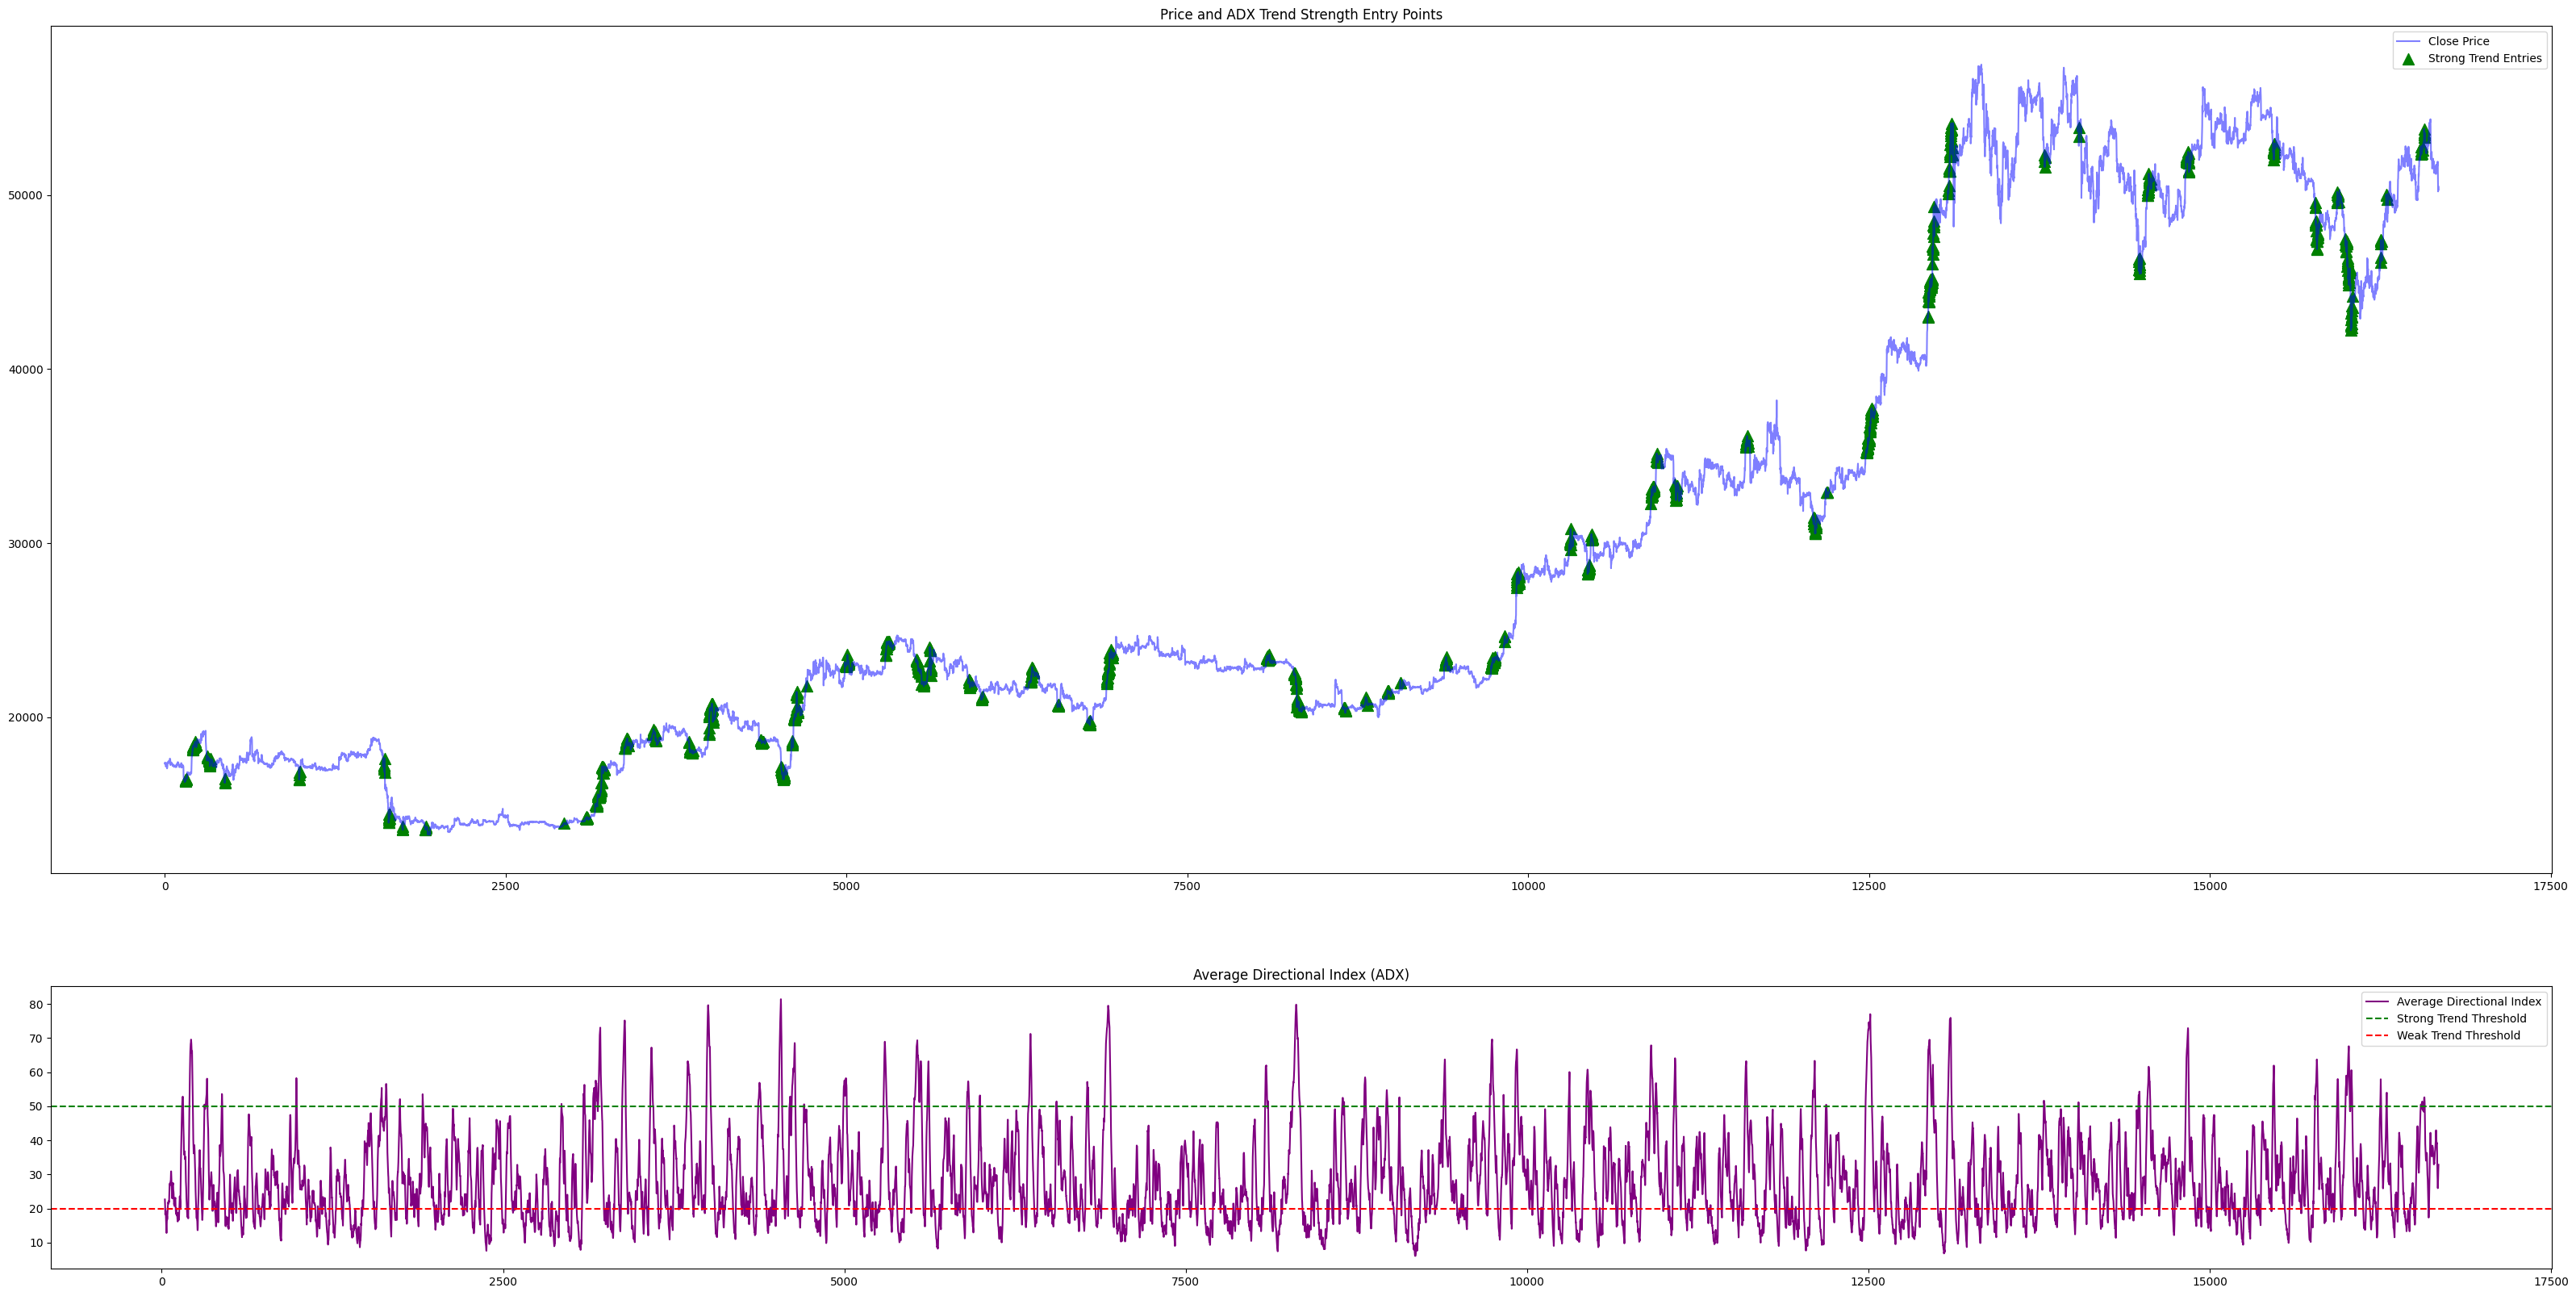

In [40]:
# Calculate ADX using pandas_ta
data['adx'] = pta.adx(data['high'], data['low'], data['close'], length=12)['ADX_12']

# Define ADX trend strength thresholds
adx_strong = 50
adx_weak = 20

# Define entry points based on ADX strength
data['strong_trend_entry'] = data['adx'] > adx_strong
data['weak_trend_entry'] = data['adx'] < adx_weak

# Plotting the price and ADX for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['strong_trend_entry']], data['close'][data['strong_trend_entry']], label='Strong Trend Entries', color='green', marker='^', s=100)
#ax1.scatter(data.index[data['weak_trend_entry']], data['close'][data['weak_trend_entry']], label='Weak Trend Entries', color='red', marker='v', s=100)
ax1.set_title('Price and ADX Trend Strength Entry Points')
ax1.legend()

# Plot ADX
ax2.plot(data['adx'], label='Average Directional Index', color='purple')
ax2.axhline(adx_strong, color='green', linestyle='--', label='Strong Trend Threshold')
ax2.axhline(adx_weak, color='red', linestyle='--', label='Weak Trend Threshold')
ax2.set_title('Average Directional Index (ADX)')
ax2.legend()

plt.show()


/tmp/ipykernel_1347/3070257230.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 4.20087080e+13 1.56349214e+13]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data['mfi'] = pta.mfi(data['high'], data['low'], data['close'], data['volume'], length=mfi_length)
/tmp/ipykernel_1347/3070257230.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.66375576e+13
 2.40888603e+13 1.25302214e+13]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data['mfi'] = pta.mfi(data['high'], data['low'], data['close'], data['volume'], length=mfi_length)


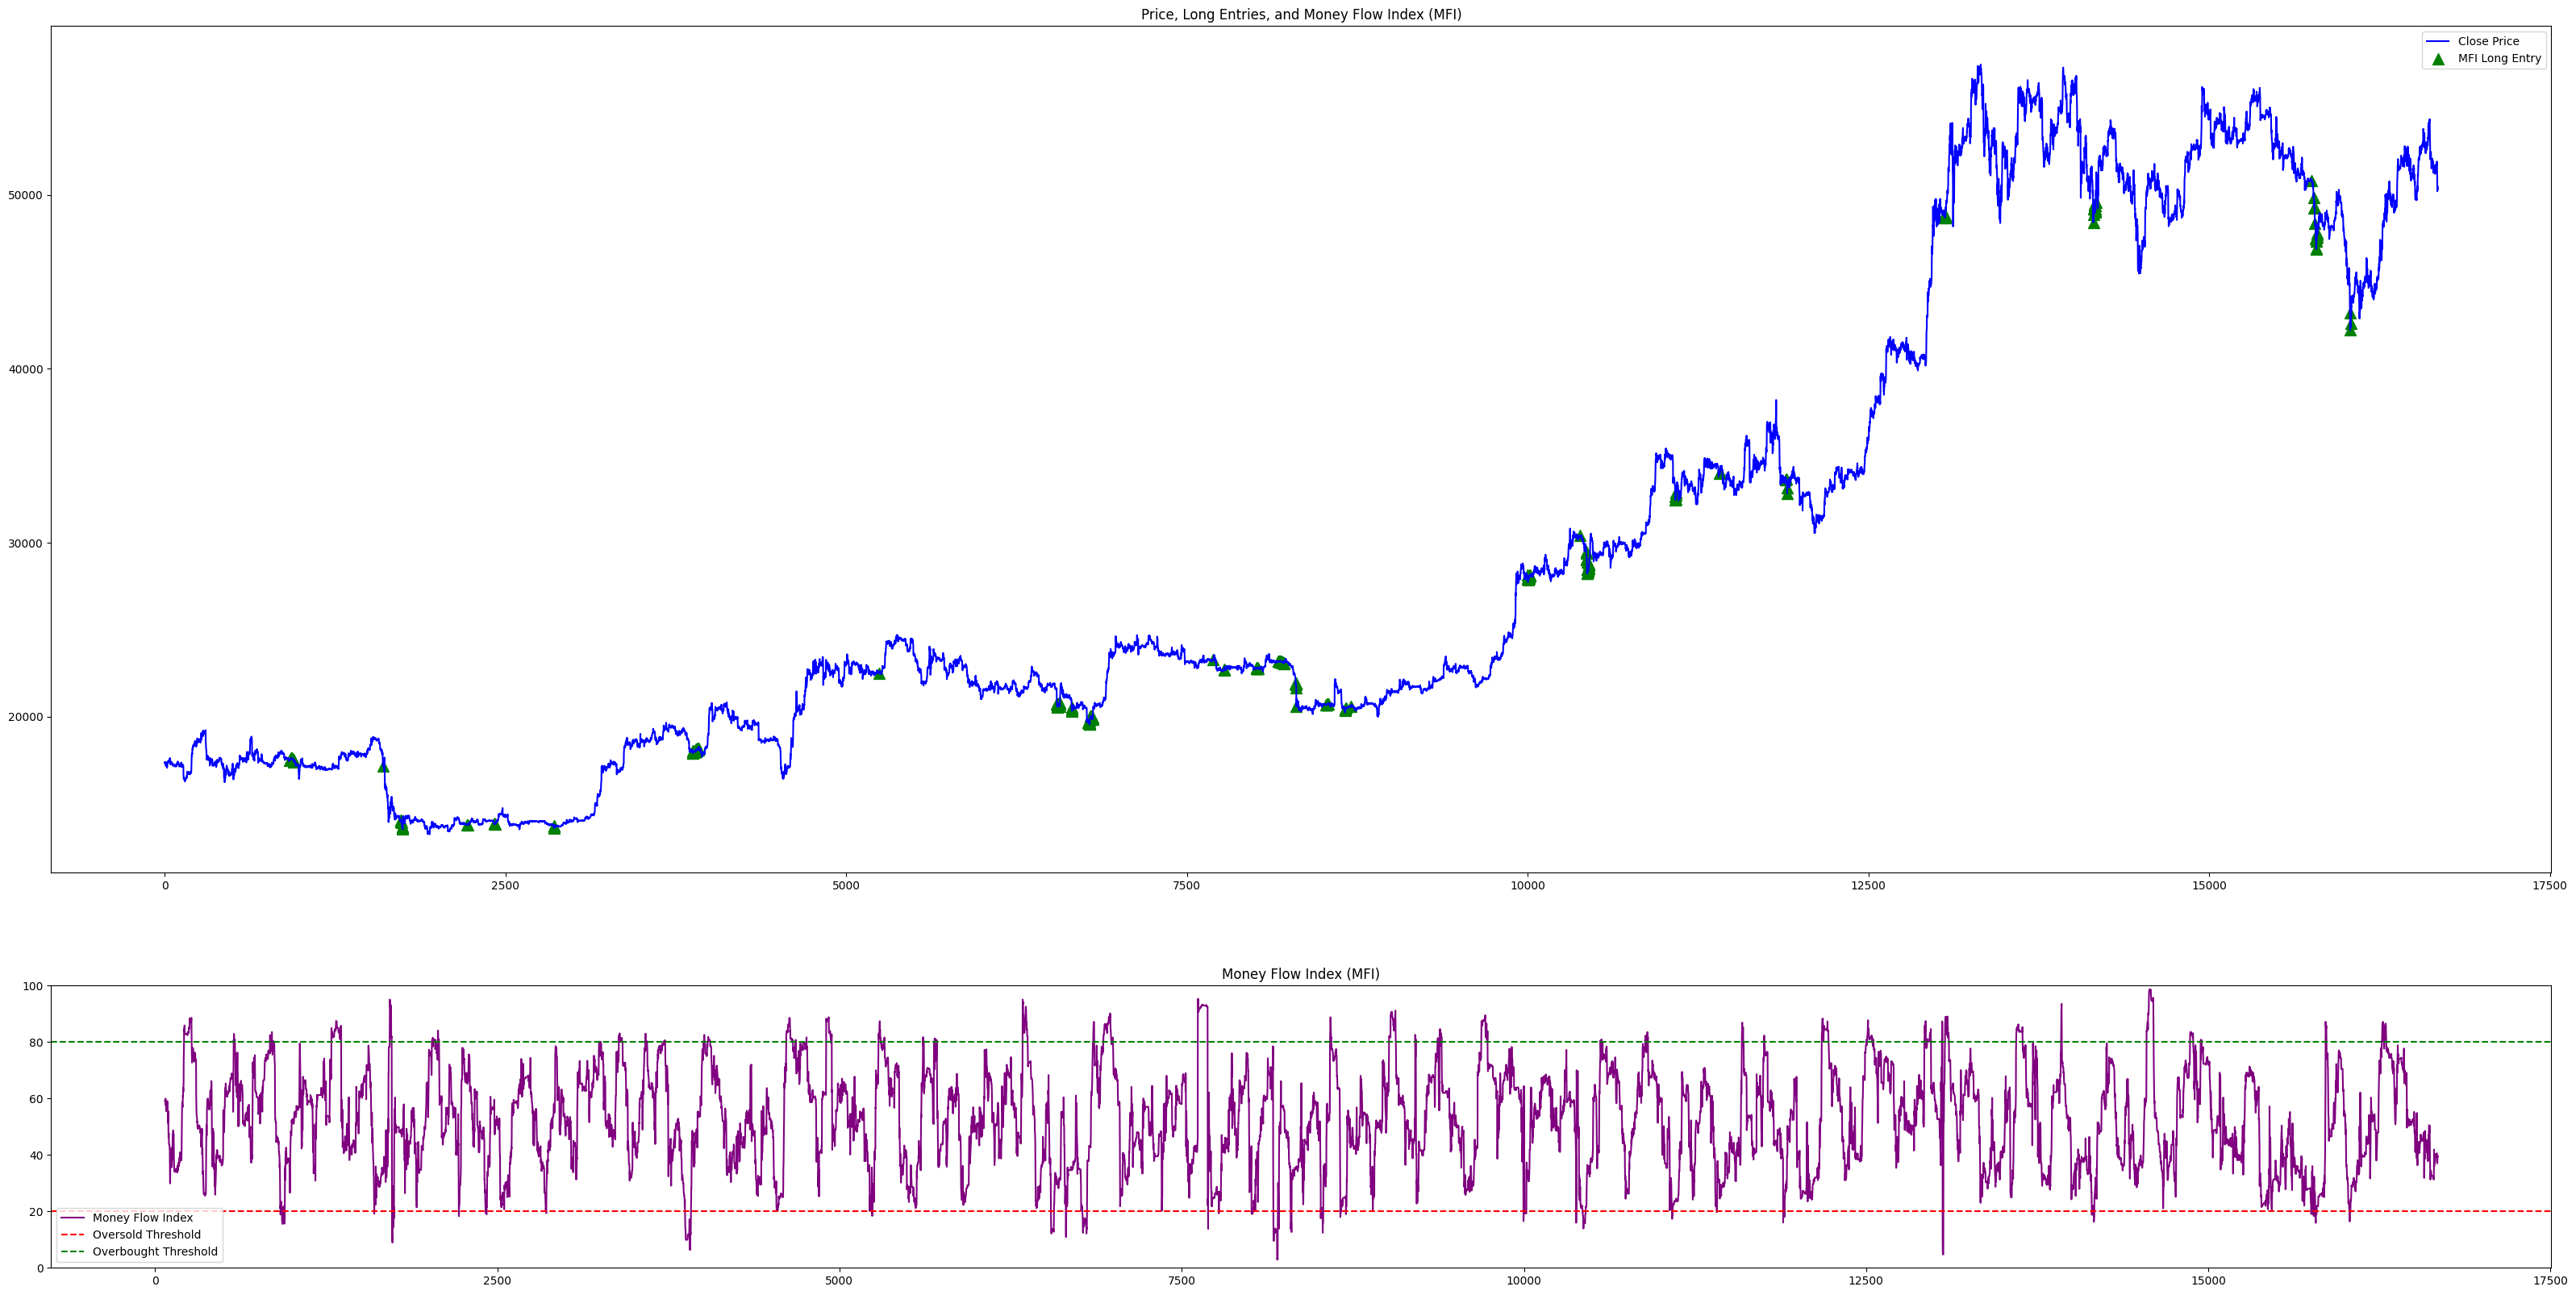

MFI Mean: 52.67
MFI Median: 52.47
MFI Min: 2.92
MFI Max: 98.71
Percentage of time MFI is oversold: 1.80%
Percentage of time MFI is overbought: 6.36%
Number of long entry signals: 300


In [48]:
# Calculate Money Flow Index (MFI)
mfi_length = 72
data['mfi'] = pta.mfi(data['high'], data['low'], data['close'], data['volume'], length=mfi_length)

# Define MFI oversold threshold
mfi_oversold = 20

# Define long entry condition based on MFI
data['mfi_long_entry'] = data['mfi'] < mfi_oversold

# Plot MFI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and long entry points
ax1.plot(data['close'], label='Close Price', color='blue')
ax1.scatter(data.index[data['mfi_long_entry']], data['close'][data['mfi_long_entry']], 
            color='green', marker='^', s=100, label='MFI Long Entry')
ax1.set_title('Price, Long Entries, and Money Flow Index (MFI)')
ax1.legend()

# Plot MFI
ax2.plot(data['mfi'], label='Money Flow Index', color='purple')
ax2.axhline(mfi_oversold, color='red', linestyle='--', label='Oversold Threshold')
ax2.axhline(100 - mfi_oversold, color='green', linestyle='--', label='Overbought Threshold')
ax2.set_title('Money Flow Index (MFI)')
ax2.set_ylim(0, 100)
ax2.legend()

plt.show()

# Print some statistics about MFI
print(f"MFI Mean: {data['mfi'].mean():.2f}")
print(f"MFI Median: {data['mfi'].median():.2f}")
print(f"MFI Min: {data['mfi'].min():.2f}")
print(f"MFI Max: {data['mfi'].max():.2f}")
print(f"Percentage of time MFI is oversold: {(data['mfi'] < mfi_oversold).mean() * 100:.2f}%")
print(f"Percentage of time MFI is overbought: {(data['mfi'] > (100 - mfi_oversold)).mean() * 100:.2f}%")
print(f"Number of long entry signals: {data['mfi_long_entry'].sum()}")


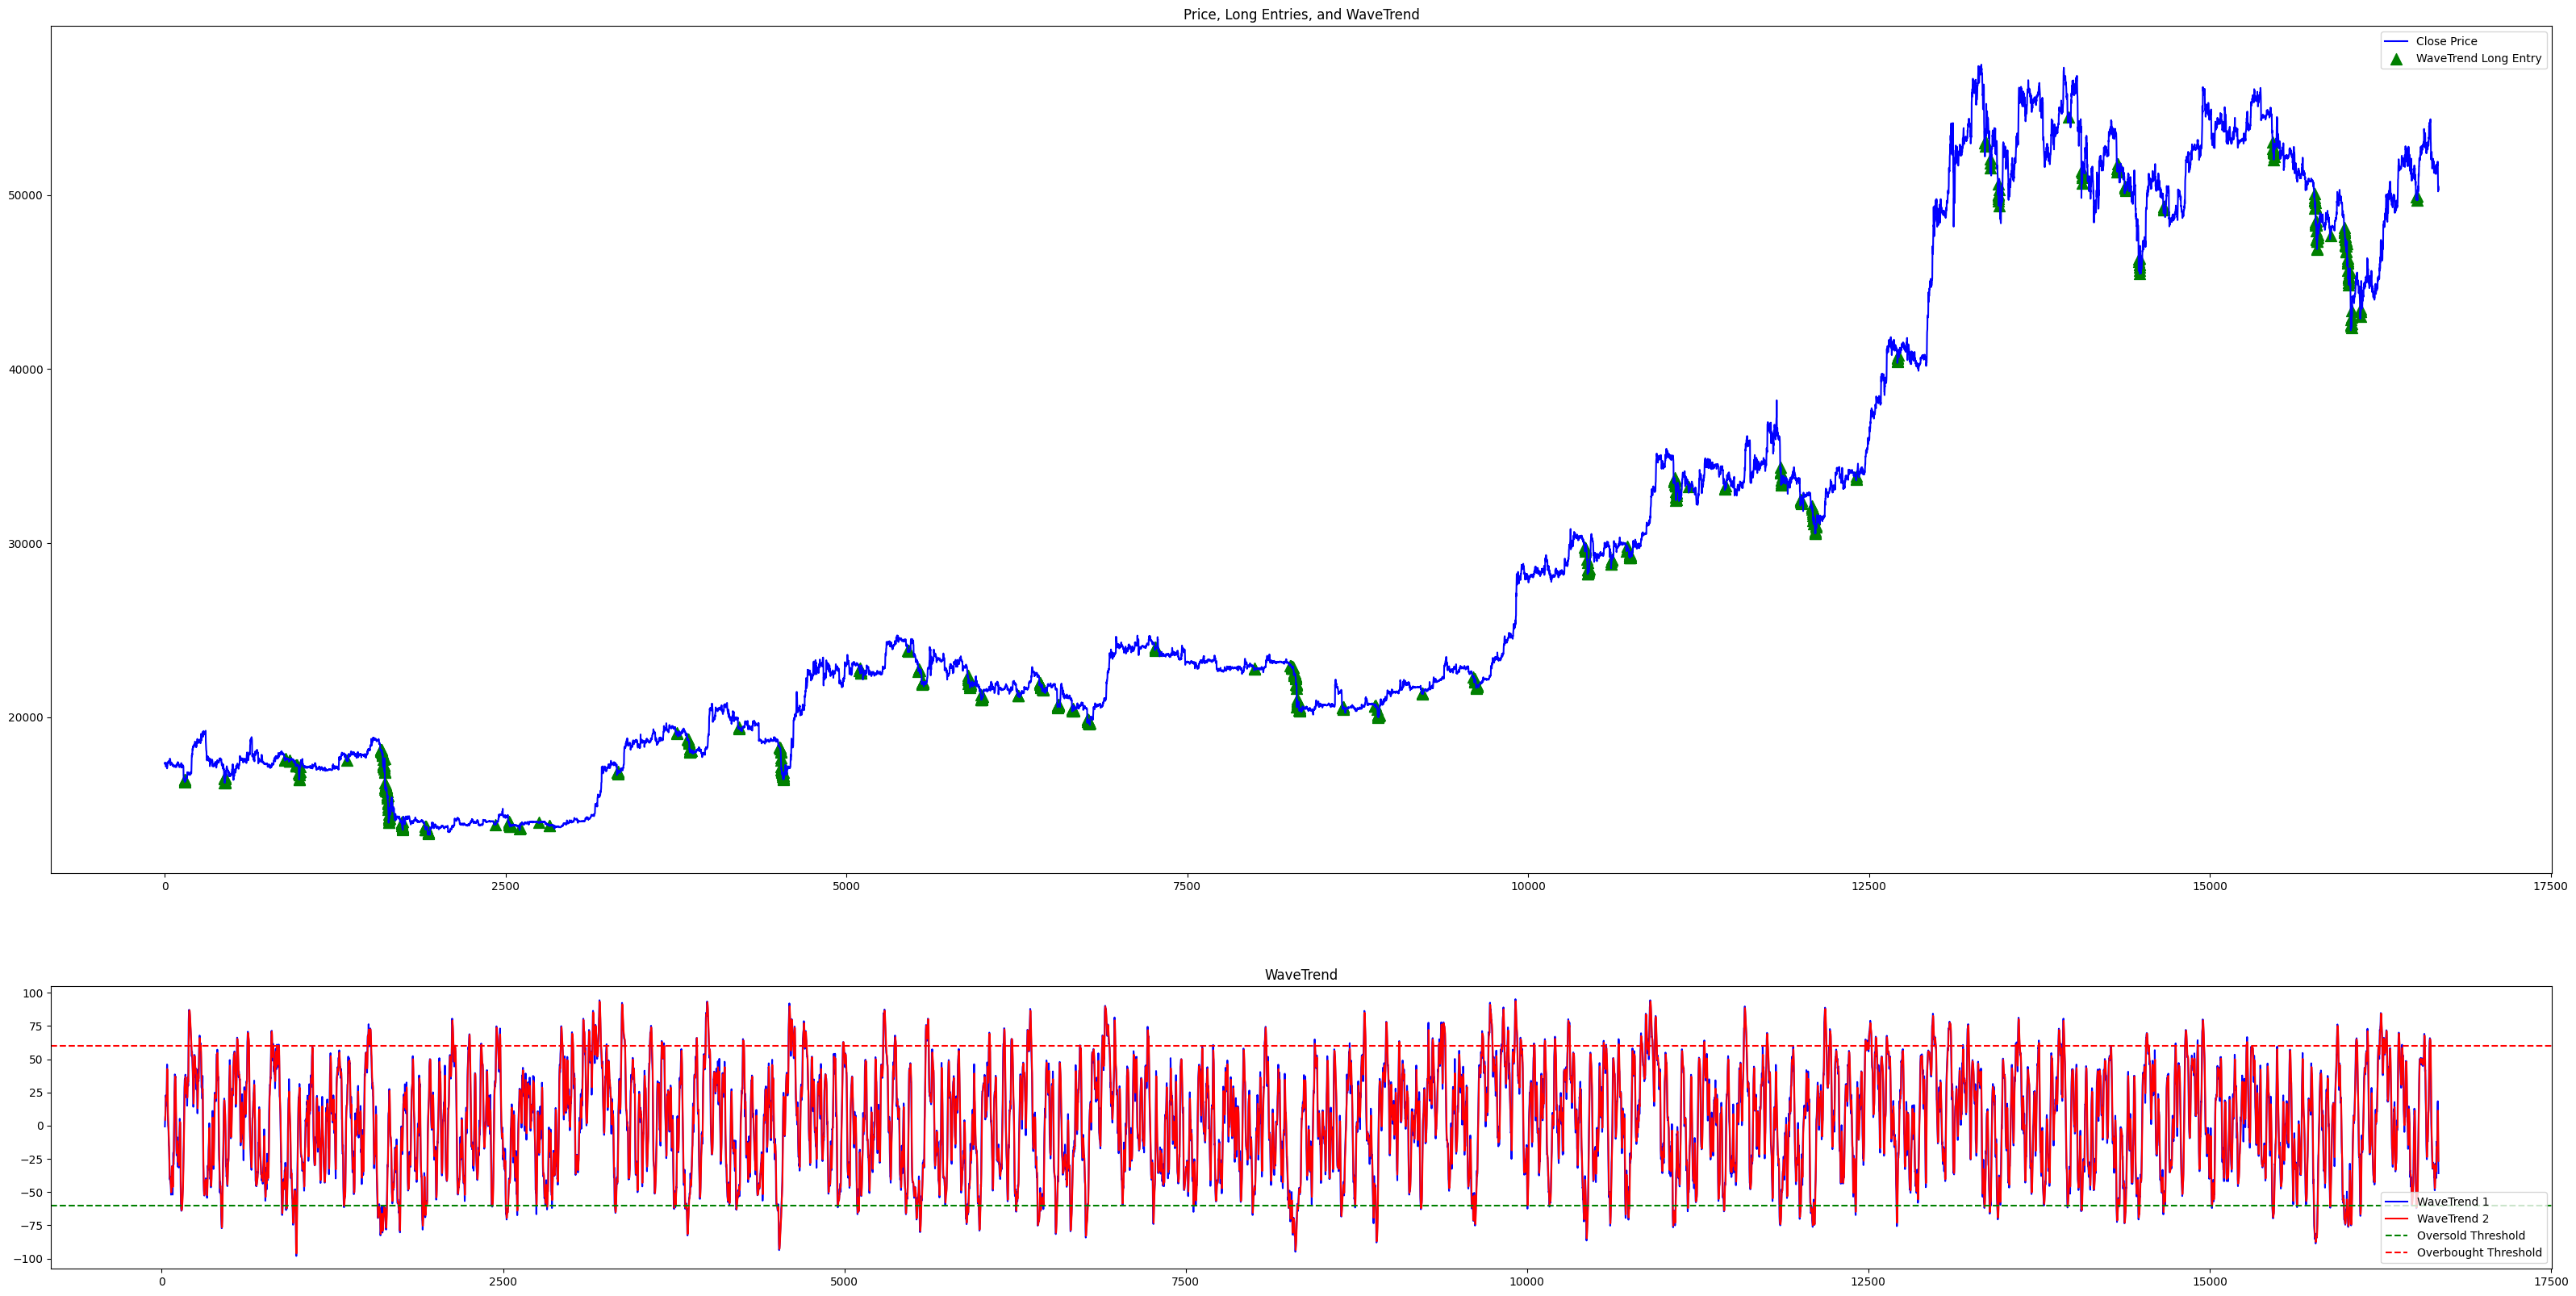

WT1 Mean: 3.54
WT1 Median: 4.70
WT1 Min: -98.10
WT1 Max: 95.18
Percentage of time WT1 is oversold: 5.13%
Percentage of time WT1 is overbought: 7.24%
Number of long entry signals: 696


In [50]:
# Calculate WaveTrend
n1 = 12
n2 = 24

ap = (data['high'] + data['low'] + data['close']) / 3
esa = pta.ema(ap, length=n1)
d = pta.ema(abs(ap - esa), length=n1)
ci = (ap - esa) / (0.015 * d)
tci = pta.ema(ci, length=n2)

data['wt1'] = tci
data['wt2'] = pta.sma(data['wt1'], length=4)

# Define WaveTrend conditions
wt_oversold = -60
wt_overbought = 60

# Define long entry condition based on WaveTrend
data['wt_long_entry'] = (data['wt1'] < wt_oversold) & (data['wt2'] < wt_oversold)

# Plot WaveTrend
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and long entry points
ax1.plot(data['close'], label='Close Price', color='blue')
ax1.scatter(data.index[data['wt_long_entry']], data['close'][data['wt_long_entry']], 
            color='green', marker='^', s=100, label='WaveTrend Long Entry')
ax1.set_title('Price, Long Entries, and WaveTrend')
ax1.legend()

# Plot WaveTrend
ax2.plot(data['wt1'], label='WaveTrend 1', color='blue')
ax2.plot(data['wt2'], label='WaveTrend 2', color='red')
ax2.axhline(wt_oversold, color='green', linestyle='--', label='Oversold Threshold')
ax2.axhline(wt_overbought, color='red', linestyle='--', label='Overbought Threshold')
ax2.set_title('WaveTrend')
ax2.legend()

plt.show()

# Print some statistics about WaveTrend
print(f"WT1 Mean: {data['wt1'].mean():.2f}")
print(f"WT1 Median: {data['wt1'].median():.2f}")
print(f"WT1 Min: {data['wt1'].min():.2f}")
print(f"WT1 Max: {data['wt1'].max():.2f}")
print(f"Percentage of time WT1 is oversold: {(data['wt1'] < wt_oversold).mean() * 100:.2f}%")
print(f"Percentage of time WT1 is overbought: {(data['wt1'] > wt_overbought).mean() * 100:.2f}%")
print(f"Number of long entry signals: {data['wt_long_entry'].sum()}")


# Strategies

In [25]:
data = get_data_from_yfinance('SOL-GBP', start_date=pd.Timestamp('2022-11-01'), end_date=pd.Timestamp('2024-08-01'), invert_pair=False)

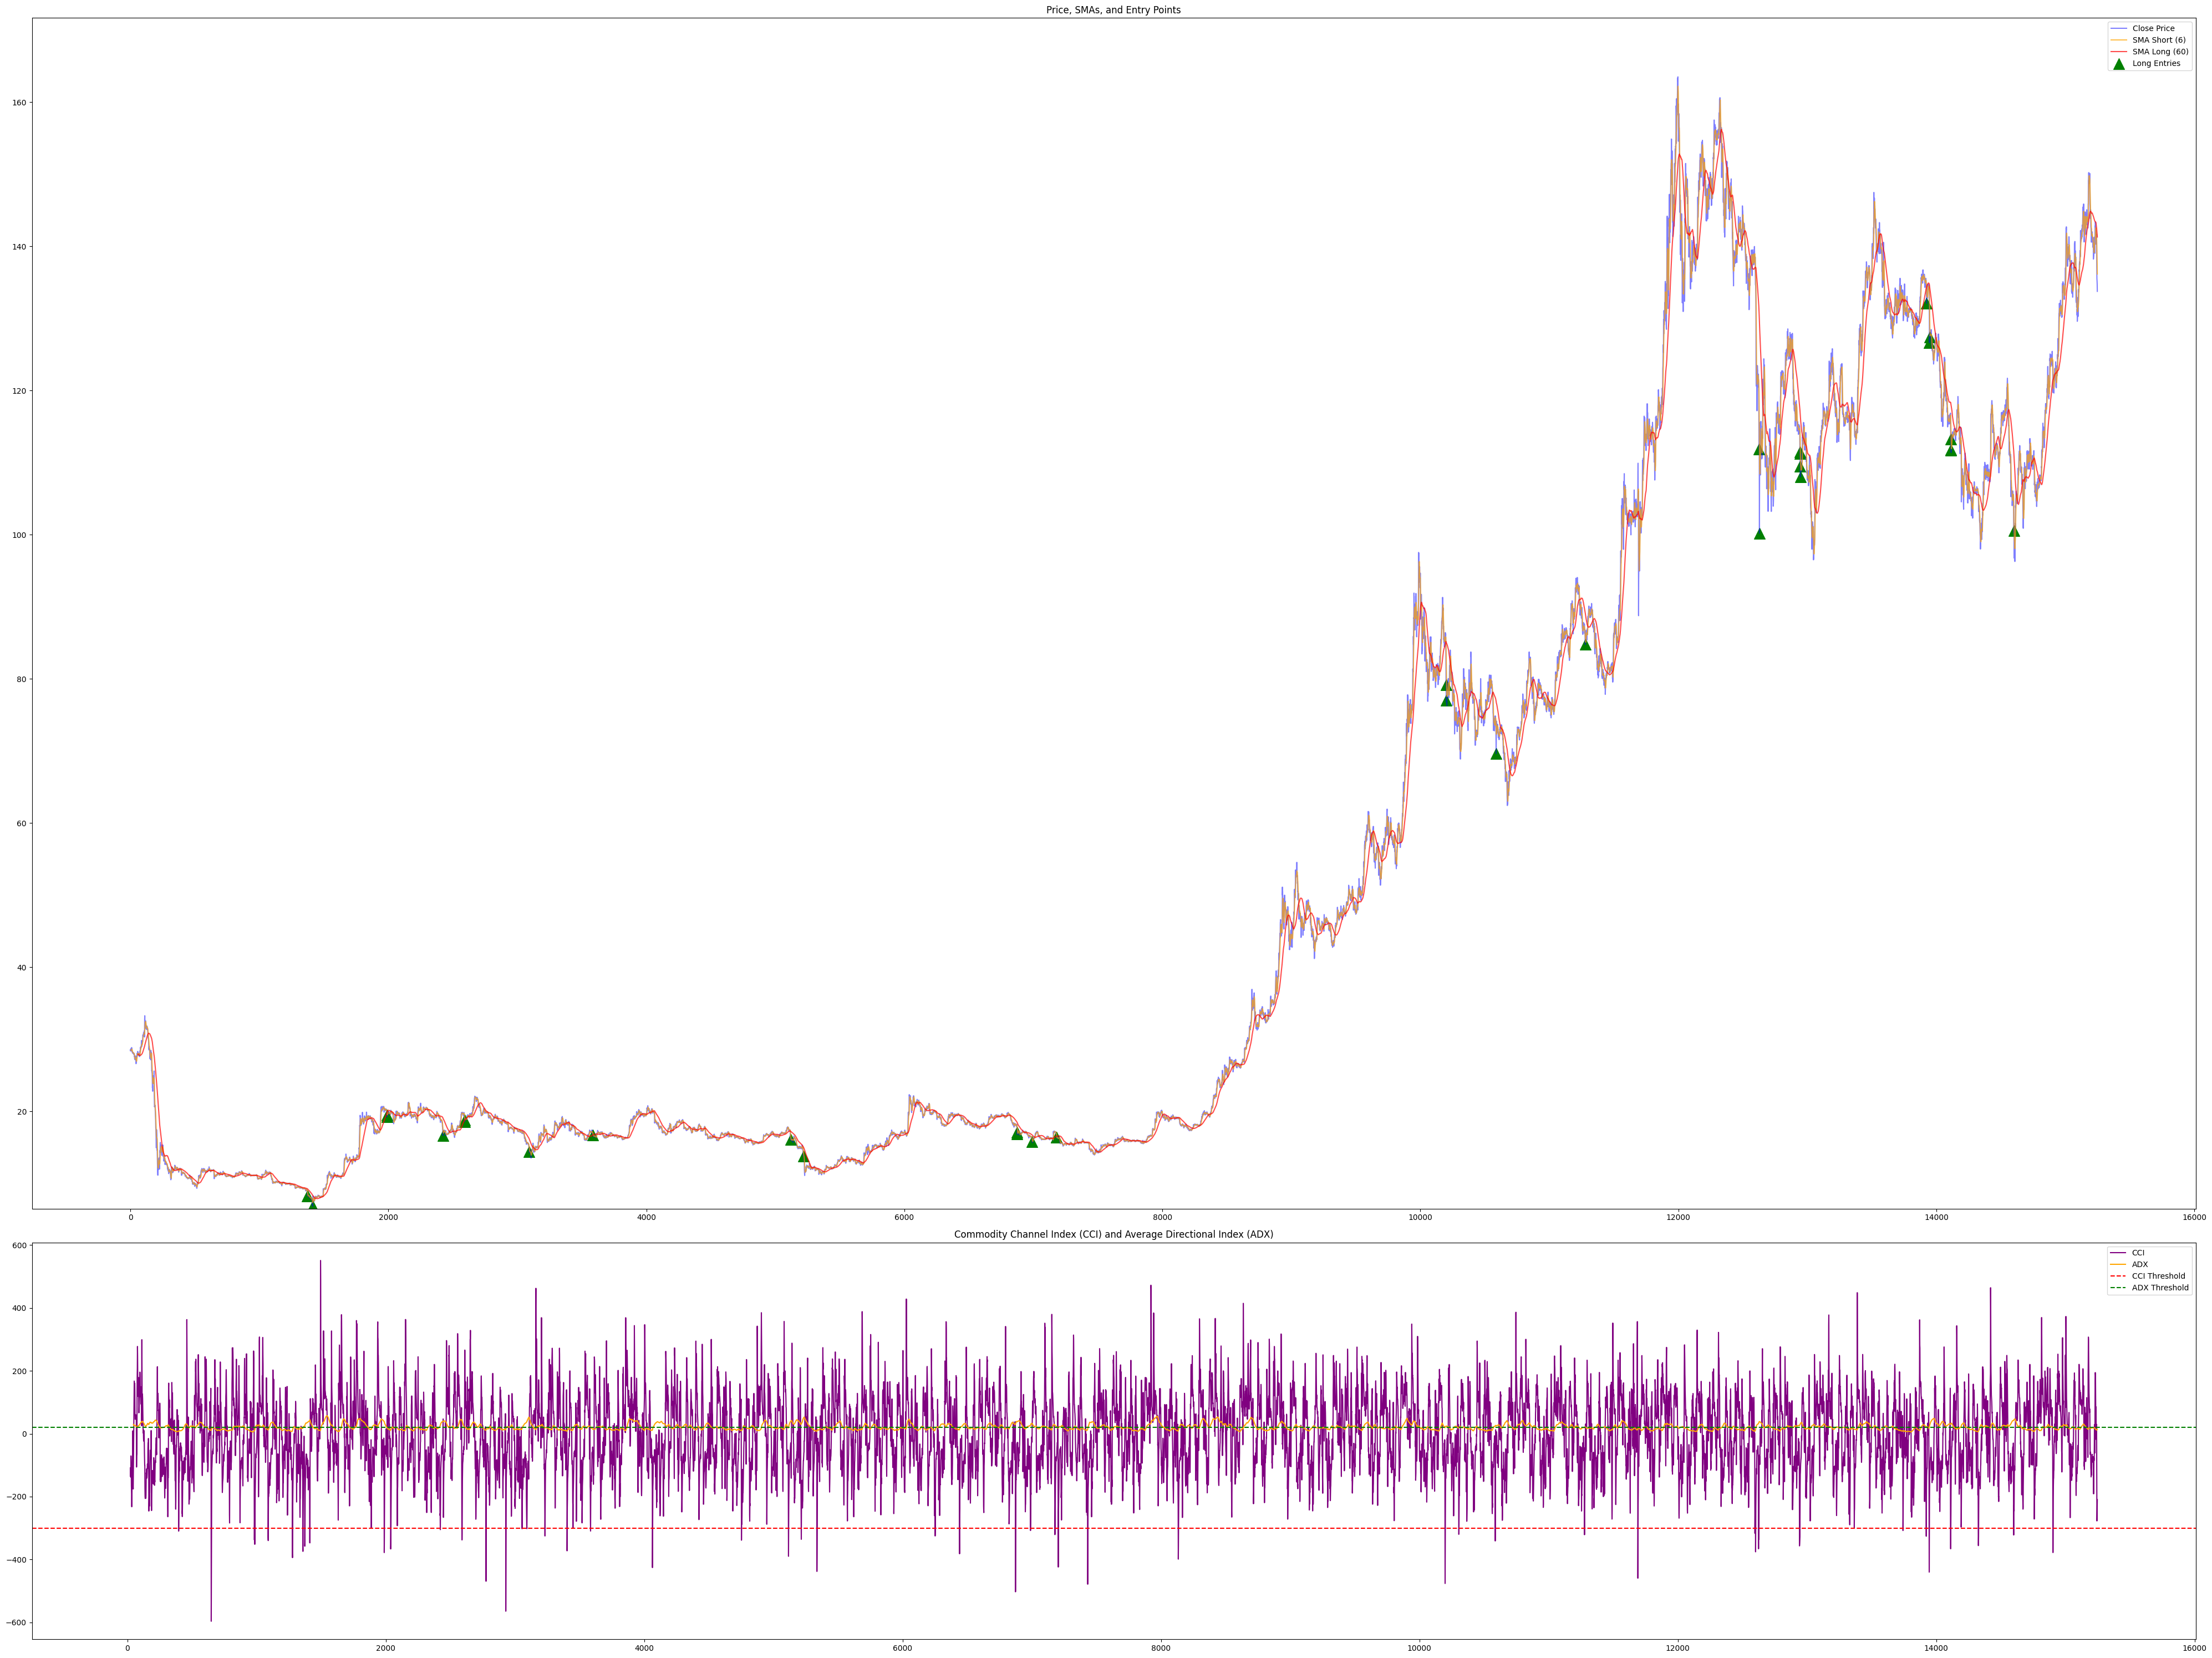

In [26]:
# AdxSmaCciStrategy

data['close_minus_1'] = data['close'].shift(1)

# Calculate CCI
cci_length = 24
data['cci'] = pta.cci(data['high'], data['low'], data['close'], length=cci_length)

# Calculate SMA
sma_length_short = 6
sma_length_long = 60
data['sma_short'] = pta.sma(data['close'], length=sma_length_short)
data['sma_short_minus_1'] = data['sma_short'].shift(1)
data['sma_long'] = pta.sma(data['close'], length=sma_length_long)
data['sma_long_minus_1'] = data['sma_long'].shift(1)

# Calculate ADX
adx_length = 24
adx = pta.adx(data['high'], data['low'], data['close'], length=adx_length)
data['adx'] = adx['ADX_' + str(adx_length)]

# Define signals
cci_threshold = -300
adx_threshold = 20
data['cci_bullish'] = (data['cci'] < cci_threshold)
data['sma_buy'] = (data['sma_short'] > data['sma_long']) & (data['close'] > data['sma_short']) & (data['close_minus_1'] < data['sma_short_minus_1'])
data['strong_trend'] = data['adx'] > adx_threshold

# Combine signals
data['long_entry'] = (
    #data['sma_buy'] &
    data['cci_bullish'] &
    data['strong_trend']
)

# Update plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 30), gridspec_kw={'height_ratios': [3, 1]})

# Plot price, SMAs, and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.plot(data['sma_short'], label=f'SMA Short ({sma_length_short})', color='orange', alpha=0.7)
ax1.plot(data['sma_long'], label=f'SMA Long ({sma_length_long})', color='red', alpha=0.7)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=200)
ax1.set_title('Price, SMAs, and Entry Points')
ax1.legend()
ax1.set_ylim(data['close'].min() * 0.95, data['close'].max() * 1.05)

# Plot CCI and ADX
ax2.plot(data['cci'], label='CCI', color='purple')
ax2.plot(data['adx'], label='ADX', color='orange')
ax2.axhline(cci_threshold, color='red', linestyle='--', label='CCI Threshold')
ax2.axhline(adx_threshold, color='green', linestyle='--', label='ADX Threshold')
ax2.set_title('Commodity Channel Index (CCI) and Average Directional Index (ADX)')
ax2.legend()

plt.tight_layout()
plt.show()


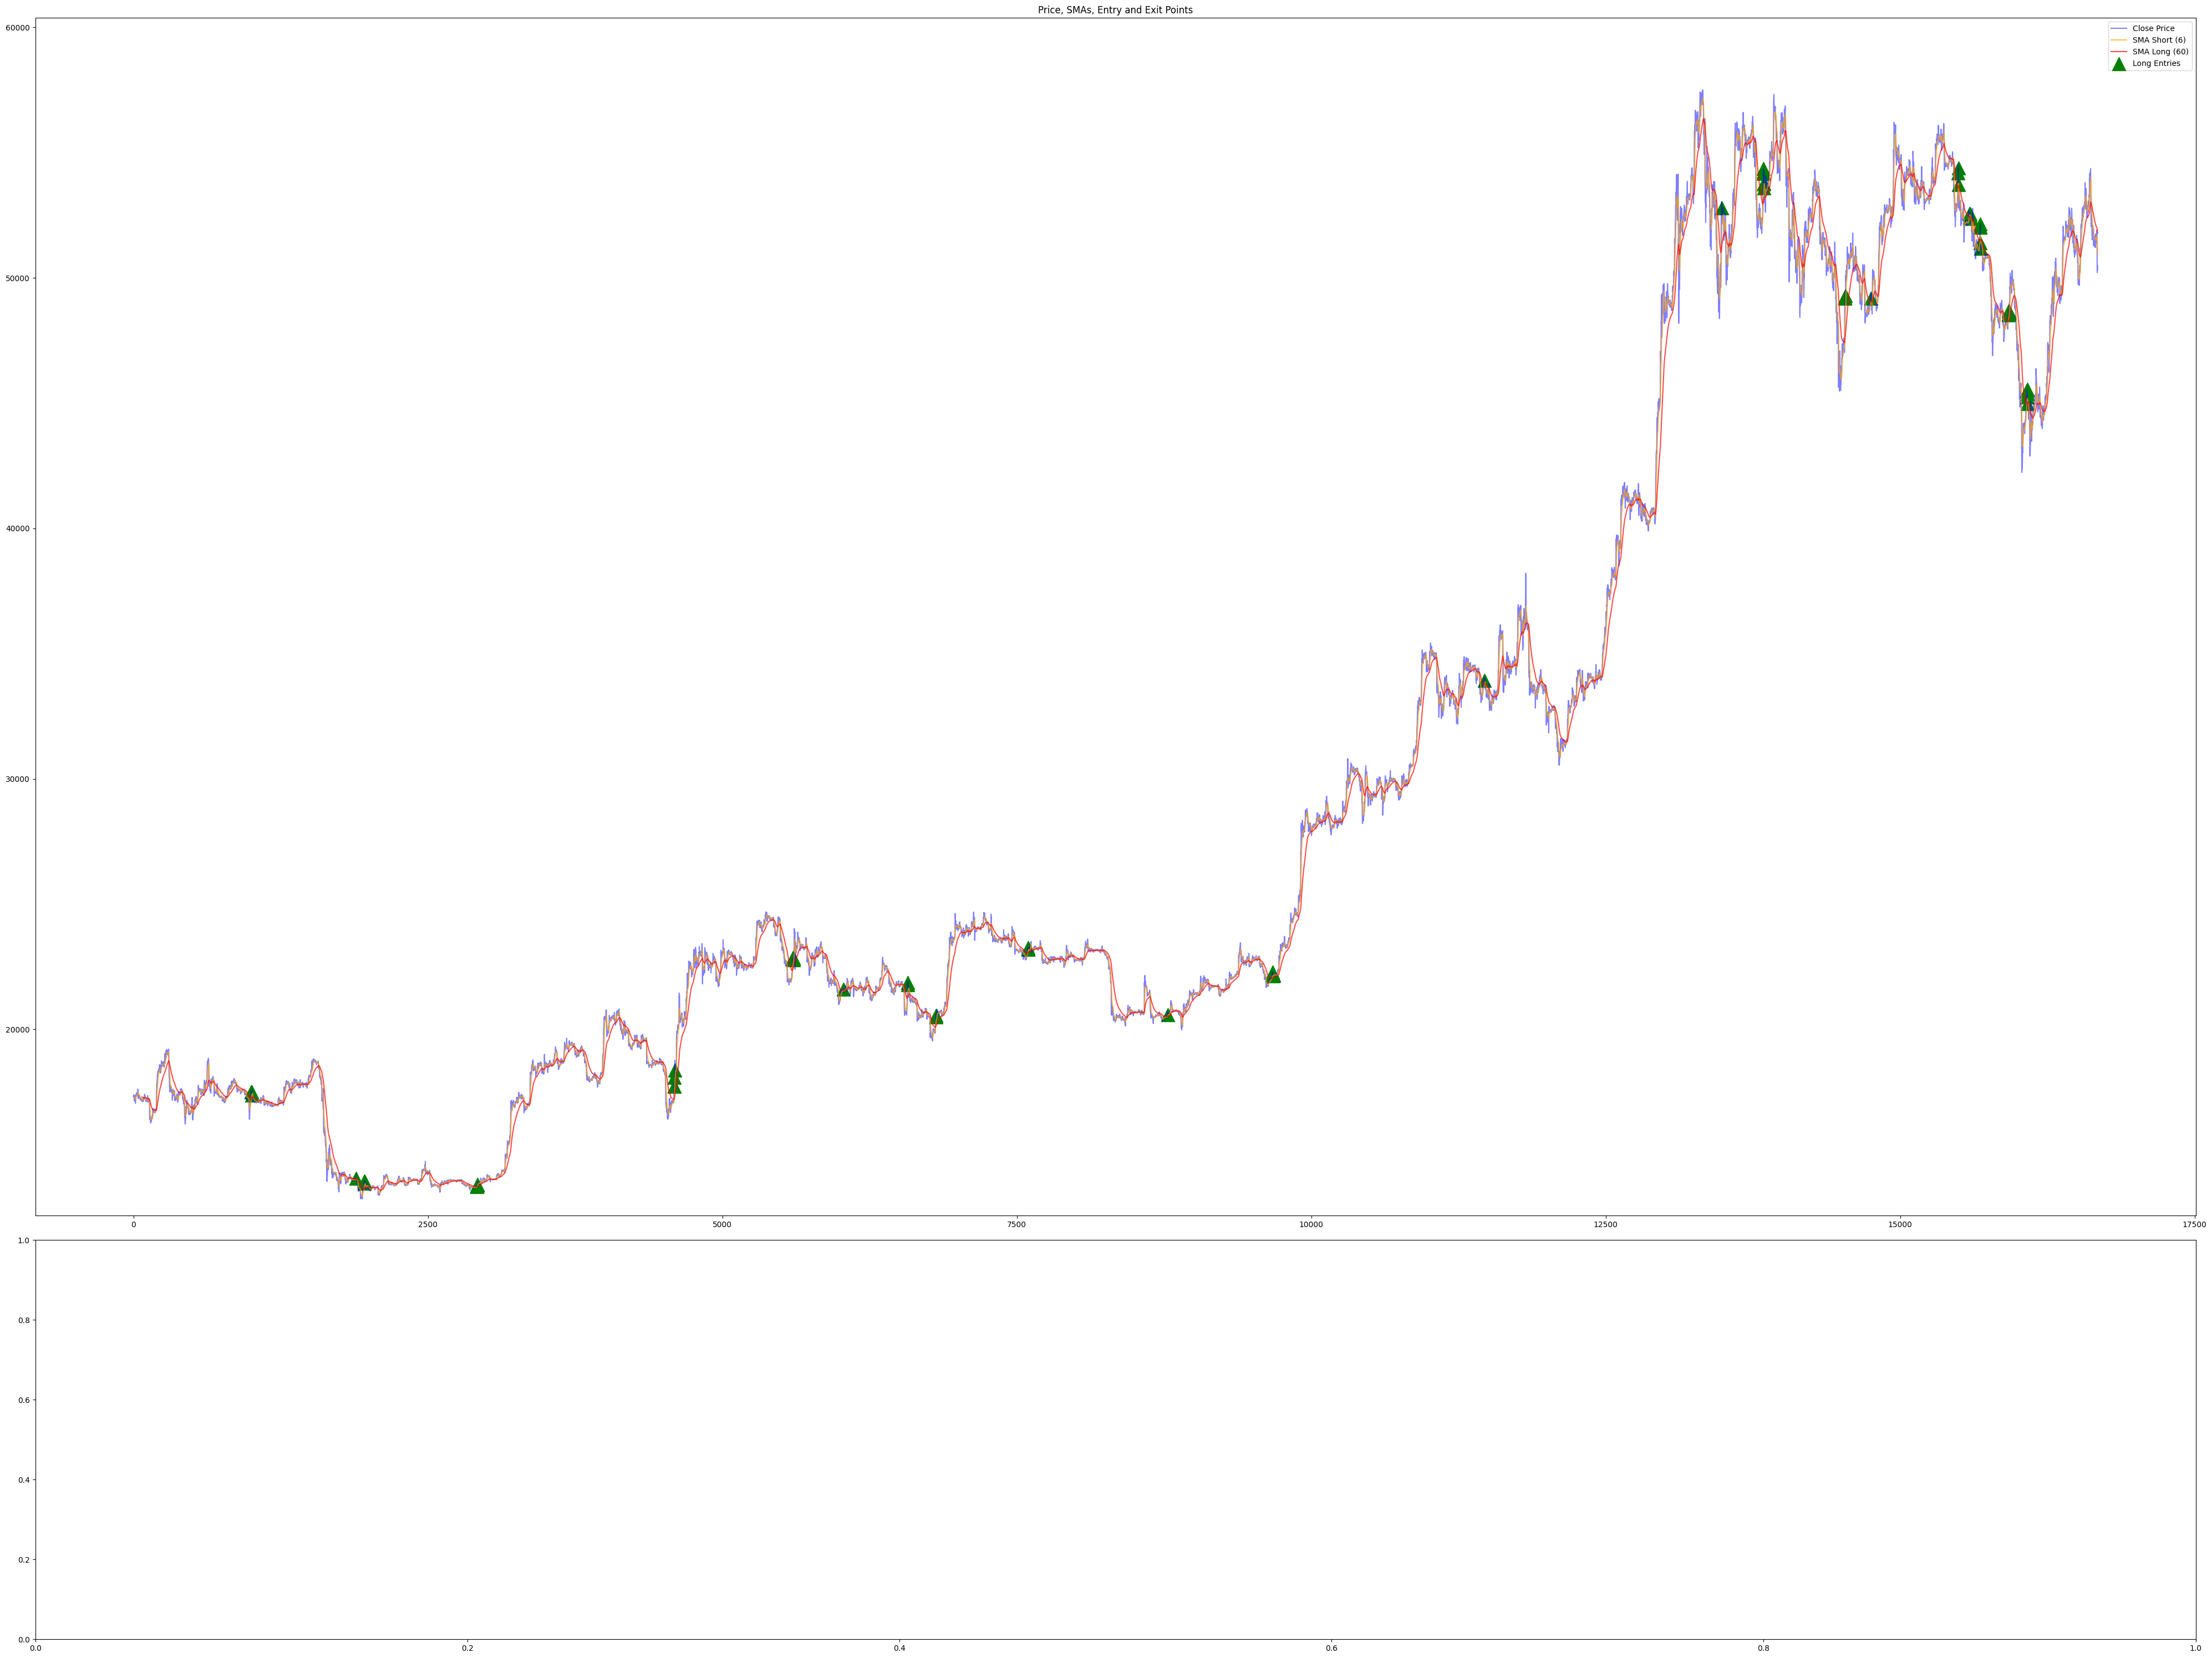

In [28]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
import pandas_ta as pta

asset = 'BTC-GBP'
#asset = 'SOL-GBP'
#asset = 'ETH-GBP'
#asset = 'ETH-BTC'
reverse_pair = False
data = get_data_from_yfinance(asset, start_date=pd.Timestamp('2022-9-01'), end_date=pd.Timestamp('2024-08-01'), invert_pair=reverse_pair)

# AdxEmaRsiStrategy

def detect_deep_v_shapes(curve_series, order):
    periods = (order // 2) - 1
    depth_threshold = curve_series.diff(periods=periods).abs().mean()
    slope_threshold = 0

    # Find local minima
    minima = argrelextrema(curve_series.values, np.less, order=order)[0]
    
    # Initialize v_shapes series with False
    v_shapes = pd.Series(False, index=curve_series.index)
    
    for idx in minima:
        if idx - order < 0 or idx + order >= len(curve_series):
            continue
        
        # Calculate left and right slopes
        left_slope = (curve_series.iloc[idx] - curve_series.iloc[idx - order]) / order
        right_slope = (curve_series.iloc[idx + order] - curve_series.iloc[idx]) / order
        
        # Check if it forms a V shape
        if left_slope < -slope_threshold and right_slope > slope_threshold:
            # Calculate depth
            depth = min(curve_series.iloc[idx - order] - curve_series.iloc[idx],
                        curve_series.iloc[idx + order] - curve_series.iloc[idx])
            
            if depth > depth_threshold:
                # Mark the V shape at its end (idx + order) instead of the lowest point
                v_shapes.iloc[idx + order] = True
    
    return v_shapes

def is_local_minima(series, lookback: int = 3):
    series_diff = series.diff(periods=1)

    # Ensure the lookback value is appropriate for the calculation
    if lookback < 2:
        raise ValueError("Lookback must be at least 2.")
    
    # Calculate the midpoint for splitting the lookback period
    midpoint = lookback // 2  # Integer division to ensure midpoint is an integer
    
    average_drop = series_diff[series < 0].mean()
    average_rise = series_diff[series > 0].mean()

    # Conditions for detecting a local minima
    # The first half should be decreasing (negative difference)
    conditions = [(series_diff.shift(i) < 0) for i in range(lookback-1, midpoint-1, -1)]
    
    # The second half should be increasing (positive difference)
    conditions.extend([(series_diff.shift(i) > 0) for i in range(midpoint-1, -1, -1)])
    
    # Check if all conditions are met
    return pd.concat(conditions, axis=1).all(axis=1)

data['sma_very_short'] = pta.ema(data['close'], length=6)
data['sma_short'] = pta.ema(data['close'], length=12)
data['sma_long'] = pta.ema(data['close'], length=72)

# Calculate ADX
adx = pta.adx(data['high'], data['low'], data['close'], length=12)
data['adx_short'] = adx['ADX_12']

adx = pta.adx(data['high'], data['low'], data['close'], length=48)
data['adx_long'] = adx['ADX_48']

# Calculate RSI
data['rsi_short'] = pta.rsi(data['close'], length=48)
data['rsi_long'] = pta.rsi(data['close'], length=48)

data['rsi_sma_short'] = pta.rsi(data['sma_short'], length=48)
data['rsi_sma_long'] = pta.rsi(data['sma_long'], length=48)

# Apply the function to detect local minima
data['sma_long_minima'] = is_local_minima(data['sma_long'], 24)
data['sma_short_minima'] = is_local_minima(data['sma_short'], 12)

data['v_shape'] = detect_deep_v_shapes(data['sma_long'], 6)

# Define signals
data['strong_trend'] = (data['adx_short'] > 30) #& (data['adx_long'] > 30)  # ADX threshold

data['rsi_not_overbought'] =  (data['rsi_sma_long'] < 20)# & (data['rsi_sma_short'] < 70)

data['sma_buy'] = (data['sma_short'] > data['sma_long']) & (data['sma_very_short'] > data['sma_short'])
data['sma_sell'] = (data['sma_very_short'] < data['sma_long'])

# Combine all conditions for long entry
data['long_entry'] = (
        (
            data['sma_buy'] &
            data['strong_trend'] &
            data['rsi_not_overbought'] #&
            #data['sma_long_minima']
            #data['v_shape']
        )
)

# Define long exit condition
data['long_exit'] = data['sma_short'] < data['sma_long']

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 30), gridspec_kw={'height_ratios': [3, 1]})

# Plot price, SMAs, and entry/exit points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.plot(data['sma_short'], label=f'SMA Short ({sma_length_short})', color='orange', alpha=0.7)
ax1.plot(data['sma_long'], label=f'SMA Long ({sma_length_long})', color='red', alpha=0.7)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=300)
#ax1.scatter(data.index[data['long_exit']], data['close'][data['long_exit']], label='Long Exits', color='red', marker='v', s=25)
ax1.set_title('Price, SMAs, Entry and Exit Points')
ax1.legend()
ax1.set_ylim(data['close'].min() * 0.95, data['close'].max() * 1.05)

plt.tight_layout()
plt.show()


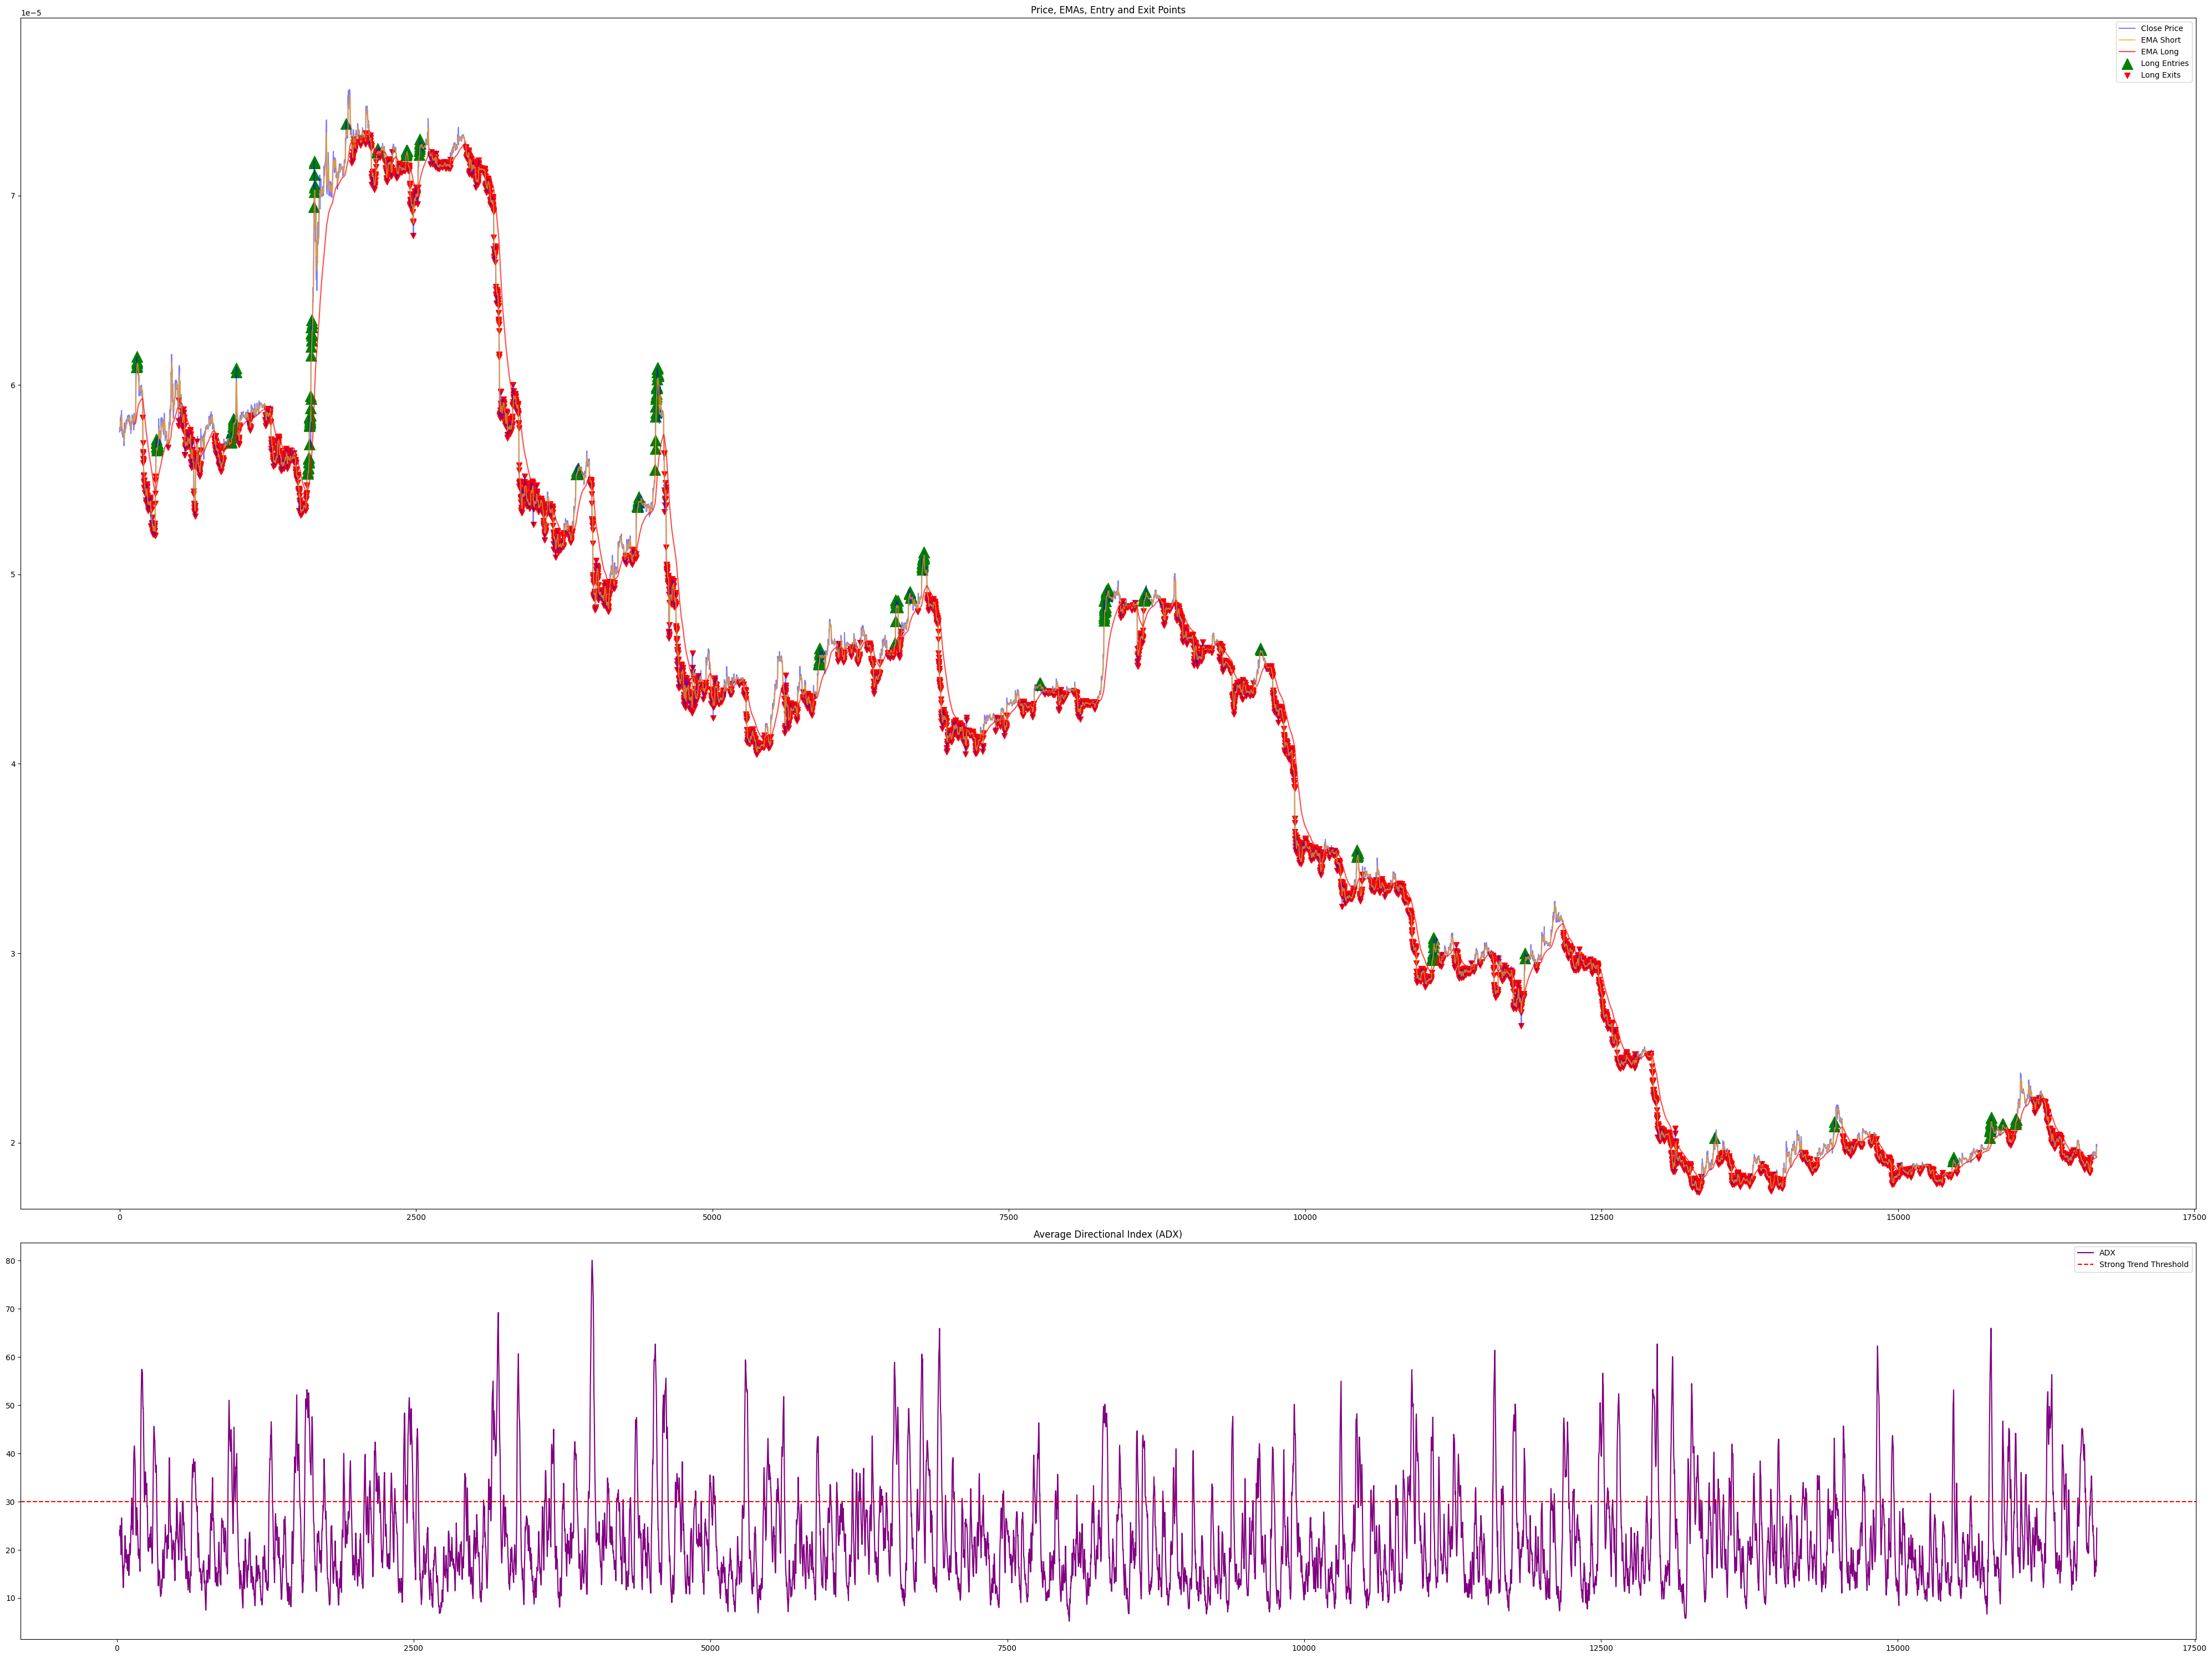

In [204]:
data = get_data_from_yfinance('BTC-GBP', start_date=pd.Timestamp('2022-09-01'), end_date=pd.Timestamp('2024-08-01'), invert_pair=True)

# AdxEmaStrategy

# Calculate ADX
adx = pta.adx(data['high'], data['low'], data['close'], length=12)
data['adx'] = adx['ADX_12']

# Calculate EMA
data['ema_short'] = pta.ema(data['close'], length=6)
data['ema_short_minus_1'] = data['ema_short'].shift(1)

data['ema_long'] = pta.ema(data['close'], length=120)
data['ema_long_minus_1'] = data['ema_long'].shift(1)
data['ema_long_gradient'] = (data['ema_long'] - data['ema_long_minus_1']) / data['ema_long_minus_1']

# Define signals
data['strong_trend'] = data['adx'] > 40
data['ema_buy'] = (data['ema_short'] > data['ema_long']) & (data['close'] > data['ema_short'])# & (data['ema_long_gradient'] > 0.0001)

# Combine all conditions for long entry
data['long_entry'] = (data['strong_trend'] & data['ema_buy'])

# Define long exit condition
data['long_exit'] = (data['ema_short'] < data['ema_long'])

# Update plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 30), gridspec_kw={'height_ratios': [3, 1]})

# Plot price, EMAs, and entry/exit points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.plot(data['ema_short'], label='EMA Short', color='orange', alpha=0.7)
ax1.plot(data['ema_long'], label='EMA Long', color='red', alpha=0.7)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=200)
ax1.scatter(data.index[data['long_exit']], data['close'][data['long_exit']], label='Long Exits', color='red', marker='v', s=50)
ax1.set_title('Price, EMAs, Entry and Exit Points')
ax1.legend()
ax1.set_ylim(data['close'].min() * 0.95, data['close'].max() * 1.05)

# Plot ADX
ax2.plot(data['adx'], label='ADX', color='purple')
ax2.axhline(30, color='red', linestyle='--', label='Strong Trend Threshold')
ax2.set_title('Average Directional Index (ADX)')
ax2.legend()

plt.tight_layout()
plt.show()


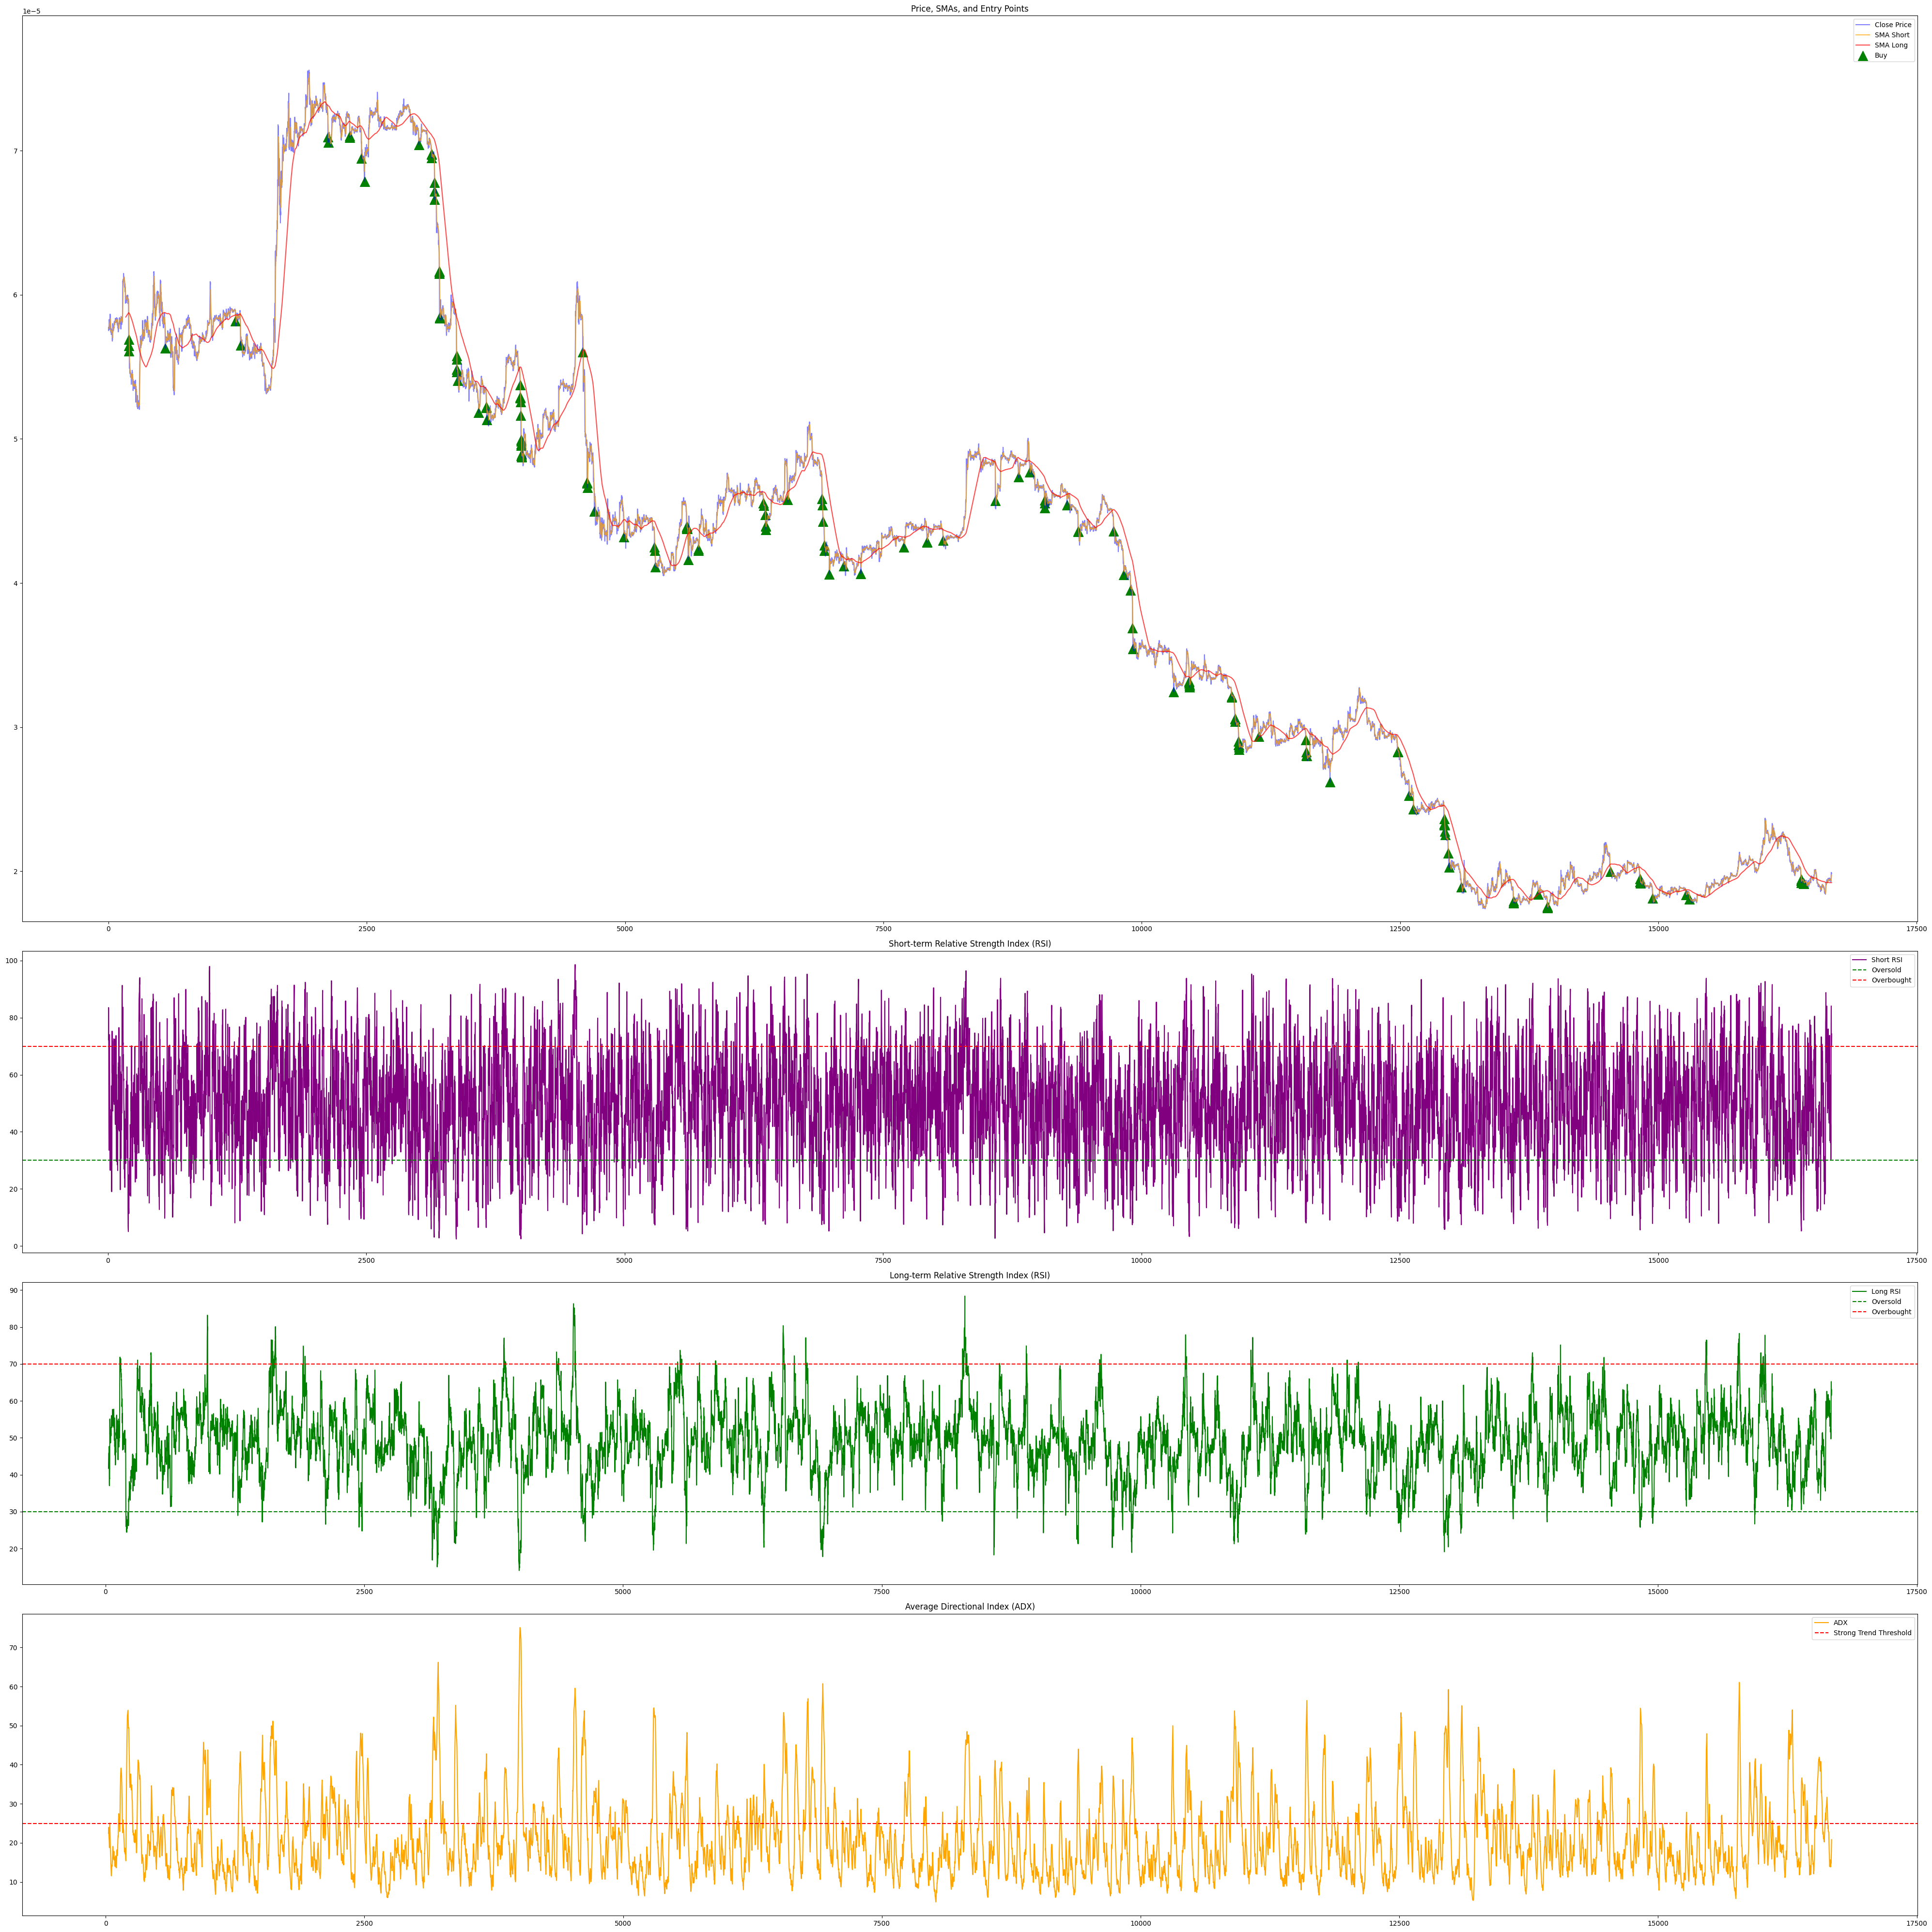

Total long entries: 164
Entry rate: 0.98%


In [205]:
# Calculate RSI for short and long periods
data['rsi_short'] = pta.rsi(data['close'], length=6)
data['rsi_long'] = pta.rsi(data['close'], length=28)

# Calculate SMA for short and long periods
data['sma_short'] = pta.sma(data['close'], length=6)
data['sma_long'] = pta.sma(data['close'], length=168)

# Calculate ADX to filter out weak trends
data['adx'] = pta.adx(data['high'], data['low'], data['close'], length=14)['ADX_14']

# Define conditions for long entry
data['rsi_short_oversold'] = data['rsi_short'] < 10
data['rsi_long_not_overbought'] = data['rsi_long'] < 40
data['sma_short_over_long'] = data['sma_short'] > data['sma_long']
data['strong_trend'] = data['adx'] > 30  # Filter out weak trends

# Combine all conditions for long entry
data['long_entry'] = (
    data['rsi_short_oversold'] &
    data['rsi_long_not_overbought'] #&
    #data['sma_short_over_long'] &
    #data['strong_trend']  # Include strong trend condition
)

# Plotting
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(40, 40), gridspec_kw={'height_ratios': [3, 1, 1, 1]})

# Plot price, SMAs, and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.plot(data['sma_short'], label='SMA Short', color='orange', alpha=0.7)
ax1.plot(data['sma_long'], label='SMA Long', color='red', alpha=0.7)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Buy', color='green', marker='^', s=200)
ax1.set_title('Price, SMAs, and Entry Points')
ax1.legend()
ax1.set_ylim(data['close'].min() * 0.95, data['close'].max() * 1.05)

# Plot short RSI
ax2.plot(data['rsi_short'], label='Short RSI', color='purple')
ax2.axhline(30, color='green', linestyle='--', label='Oversold')
ax2.axhline(70, color='red', linestyle='--', label='Overbought')
ax2.set_title('Short-term Relative Strength Index (RSI)')
ax2.legend()

# Plot long RSI
ax3.plot(data['rsi_long'], label='Long RSI', color='green')
ax3.axhline(30, color='green', linestyle='--', label='Oversold')
ax3.axhline(70, color='red', linestyle='--', label='Overbought')
ax3.set_title('Long-term Relative Strength Index (RSI)')
ax3.legend()

# Plot ADX
ax4.plot(data['adx'], label='ADX', color='orange')
ax4.axhline(25, color='red', linestyle='--', label='Strong Trend Threshold')
ax4.set_title('Average Directional Index (ADX)')
ax4.legend()

plt.tight_layout()
plt.show()

# Print summary
total_entries = data['long_entry'].sum()
print(f"Total long entries: {total_entries}")
print(f"Entry rate: {total_entries/len(data):.2%}")
